# Extracellular proteases study in *B. subtilis* biofilm

In [1]:
from platform import python_version
print(python_version())

3.10.11


In [78]:
#IMPORT PACKAGES
from os import listdir
from os.path import isfile, join
import glob

import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
from bioinfokit.analys import stat
from scipy import stats

import skimage as skm
from skimage import filters
from readlif.reader import LifFile
from PIL import Image

## Biofilm footprint area on MSgg

In [3]:
#IMPORT IMAGES
image_name_list = [f for f in listdir(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_WT-D8') if isfile(join(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_WT-D8', f))]
image_list = []
for filename in glob.glob(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_WT-D8\*.JPG'):
    im=Image.open(filename)
    image_list.append(im)

#CROP IMAGES
image_crop_list = []
for i in image_list:
    width, height = i.size
    
    left = width/5
    top = height / 8
    right = (width/5)*4
    bottom = (height/8)*7
    
    image_crop = i.crop((left, top, right, bottom))
    image_crop_list.append(image_crop)

#CONVERT IMAGES TO GRAYSCALE
image_gray_list =[]
for i in image_crop_list:
    image_gray = i.convert('L')
    image_gray_list.append(image_gray)
    
#EXTRACT MATRIX FROM IMAGE
image_matrix_list = []
for i in image_gray_list:
    image_matrix = np.asarray(i)
    image_matrix_list.append(image_matrix)

#CREATING A DATASET
image_dataset = pd.DataFrame()
image_dataset['Name'] = image_name_list
image_dataset['Pixel_value'] = image_matrix_list
image_dataset.head()

Name                                        Pixel_value
0  D1_MSgg_D8_1.JPG  [[15, 16, 16, 17, 18, 18, 19, 19, 19, 20, 21, ...
1  D1_MSgg_D8_2.JPG  [[22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 17, ...
2  D1_MSgg_D8_3.JPG  [[22, 25, 26, 28, 31, 37, 44, 50, 53, 49, 41, ...
3  D1_MSgg_D8_4.JPG  [[27, 27, 26, 24, 23, 20, 17, 18, 21, 23, 23, ...
4  D1_MSgg_D8_5.JPG  [[27, 29, 28, 26, 25, 24, 21, 20, 19, 17, 17, ...

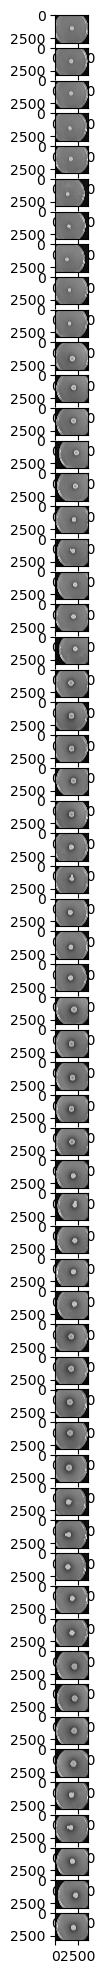

In [4]:
#DATASET VISUALISATION
fig, axs = plt.subplots(ncols=1, nrows=len(image_dataset['Name']), figsize=(15,25))

for i in range(len(image_dataset['Name'])):    
    axs[i].imshow(image_dataset.loc[i,'Pixel_value'], cmap=plt.cm.gray)

plt.show()

In [5]:
#GROUPING DATA BY MEDIA AND MIXING CONDITIONS

day = []
for index, rows in image_dataset.iterrows():
    Img_name = image_dataset.loc[index,'Name']
    if 'D1' in Img_name:
        day.append('D1')
    elif 'D2' in Img_name:
        day.append('D2')
    elif 'D3' in Img_name:
        day.append('D3')
    elif 'D4' in Img_name:
        day.append('D4')  
    elif 'D5' in Img_name:
        day.append('D5')        
    elif 'D6' in Img_name:
        day.append('D6')        
image_dataset['Day'] = day

strain = []
for index, rows in image_dataset.iterrows():
    Img_name = image_dataset.loc[index,'Name']
    if 'WT' in Img_name:
        strain.append('WT')
    elif 'D8' in Img_name:
        strain.append('D8')
image_dataset['Strain'] = strain

image_dataset.head(10)

Name                                        Pixel_value Day  \
0  D1_MSgg_D8_1.JPG  [[15, 16, 16, 17, 18, 18, 19, 19, 19, 20, 21, ...  D1   
1  D1_MSgg_D8_2.JPG  [[22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 17, ...  D1   
2  D1_MSgg_D8_3.JPG  [[22, 25, 26, 28, 31, 37, 44, 50, 53, 49, 41, ...  D1   
3  D1_MSgg_D8_4.JPG  [[27, 27, 26, 24, 23, 20, 17, 18, 21, 23, 23, ...  D1   
4  D1_MSgg_D8_5.JPG  [[27, 29, 28, 26, 25, 24, 21, 20, 19, 17, 17, ...  D1   
5  D1_MSgg_WT_1.JPG  [[14, 13, 13, 13, 13, 14, 17, 21, 24, 22, 23, ...  D1   
6  D1_MSgg_WT_2.JPG  [[31, 35, 37, 35, 31, 30, 26, 24, 25, 26, 24, ...  D1   
7  D1_MSgg_WT_3.JPG  [[16, 17, 20, 23, 26, 28, 27, 27, 28, 30, 32, ...  D1   
8  D1_MSgg_WT_4.JPG  [[36, 31, 26, 23, 23, 22, 19, 19, 20, 22, 21, ...  D1   
9  D1_MSgg_WT_5.JPG  [[18, 19, 20, 20, 21, 21, 21, 21, 21, 20, 18, ...  D1   

  Strain  
0     D8  
1     D8  
2     D8  
3     D8  
4     D8  
5     WT  
6     WT  
7     WT  
8     WT  
9     WT

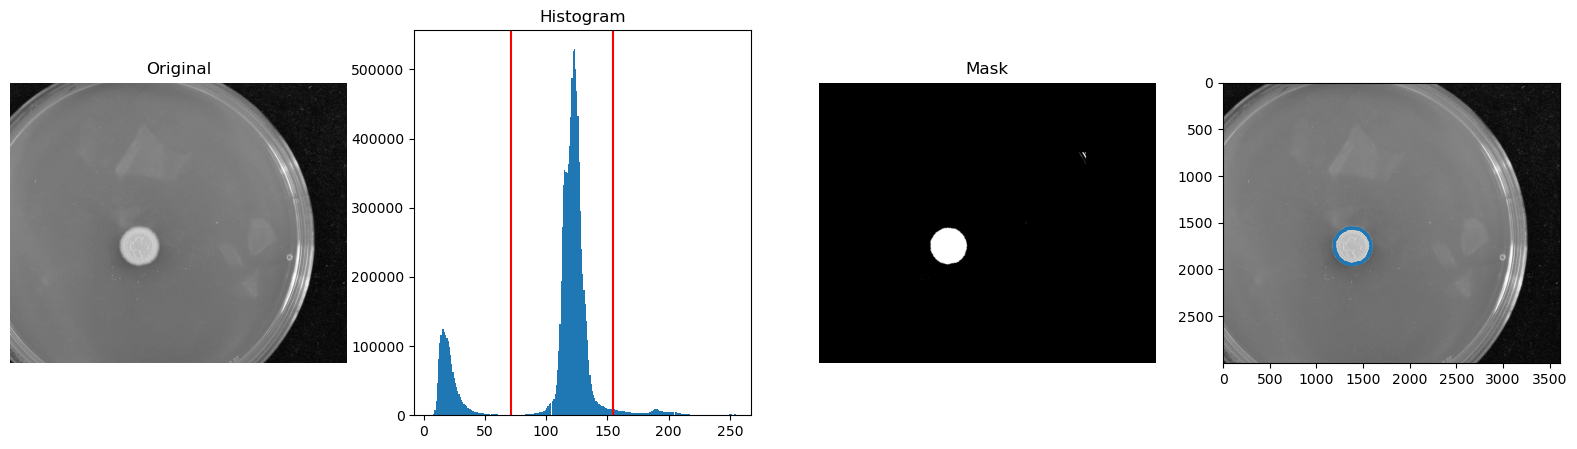

CPU times: total: 2.61 s
Wall time: 3.43 s


In [6]:
%%time

#FINDING BIOFILM EDGE
Img_test = image_dataset.loc[5,'Pixel_value']
Threshold_multiotsu = skm.filters.threshold_multiotsu(Img_test, classes=3)

Img_test_mask = Img_test > (Threshold_multiotsu[1]+25)
Img_test_fill = sc.ndimage.binary_fill_holes(Img_test_mask)

mask = Img_test_fill
mask[1:750,:] = False
mask[-750:-1,:] = False
mask[:,1:750] = False
mask[:,-750:-1] = False

Img_test_contours = skm.measure.find_contours(mask, level=False, fully_connected='high', positive_orientation='high')
Img_test_contours_clean = [a for a in Img_test_contours if len(a) > 1000]


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
# Plotting the original image.
ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(Img_test.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in Threshold_multiotsu:
    ax[1].axvline(thresh, color='r')
    
ax[2].imshow(Img_test_fill, cmap='gray')
ax[2].set_title('Mask')
ax[2].axis('off')

ax[3].imshow(Img_test, cmap=plt.cm.gray)
for contour in Img_test_contours_clean:  
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    
plt.subplots_adjust()
plt.show()

In [7]:
%%time
dataset = image_dataset

Biofilm_contour =[]

for index, rows in dataset.iterrows():
    Biofilm_image = dataset.loc[index,'Pixel_value']
    
    #Dividing histogram signal into three classes
    Threshold_multiotsu = skm.filters.threshold_multiotsu(Biofilm_image, classes=3)
    
    #Removing background signal in the mask
    Img_mask = Biofilm_image > (Threshold_multiotsu[1]+25) 
    
    #Filling holes in the mask
    Img_fill = sc.ndimage.binary_fill_holes(Img_mask)
    
    #Remving 500 pixels from each side of the image
    mask = Img_fill
    mask[1:750,:] = False
    mask[-750:-1,:] = False
    mask[:,1:750] = False
    mask[:,-750:-1] = False
    
    #Finding biofilm image
    Img_contours = skm.measure.find_contours(mask, level=False, fully_connected='high', positive_orientation='high')
    
    #Keeping only big contours
    Img_contours_clean = [a for a in Img_contours if len(a) > 1000]
    
    Biofilm_contour.append(Img_contours_clean)

dataset['Biofilm_contour'] = Biofilm_contour

dataset.head()

CPU times: total: 33.8 s
Wall time: 38.1 s


Name                                        Pixel_value Day  \
0  D1_MSgg_D8_1.JPG  [[15, 16, 16, 17, 18, 18, 19, 19, 19, 20, 21, ...  D1   
1  D1_MSgg_D8_2.JPG  [[22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 17, ...  D1   
2  D1_MSgg_D8_3.JPG  [[22, 25, 26, 28, 31, 37, 44, 50, 53, 49, 41, ...  D1   
3  D1_MSgg_D8_4.JPG  [[27, 27, 26, 24, 23, 20, 17, 18, 21, 23, 23, ...  D1   
4  D1_MSgg_D8_5.JPG  [[27, 29, 28, 26, 25, 24, 21, 20, 19, 17, 17, ...  D1   

  Strain                                    Biofilm_contour  
0     D8  [[[1638.0, 1866.0], [1637.0, 1867.0], [1636.0,...  
1     D8  [[[1761.0, 1776.0], [1760.0, 1777.0], [1760.0,...  
2     D8  [[[1645.0, 1733.0], [1644.0, 1734.0], [1644.0,...  
3     D8  [[[1851.0, 1658.0], [1850.0, 1659.0], [1849.0,...  
4     D8  [[[1714.0, 1720.0], [1713.0, 1721.0], [1713.0,...

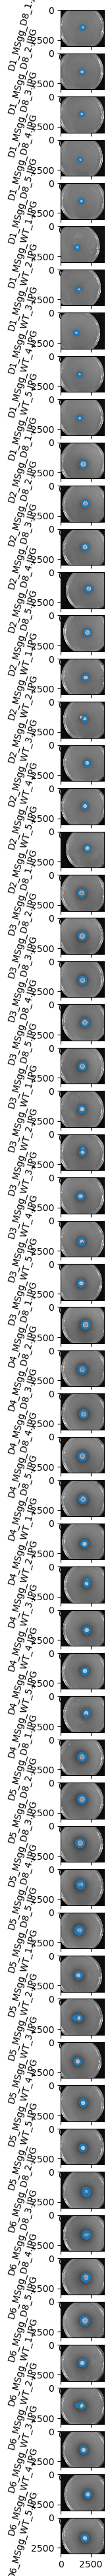

In [8]:
#CONTOUR VISUALISATION

fig, axs = plt.subplots(ncols=1, nrows=len(dataset['Name']), figsize=(5,50))

for i in range(len(dataset['Name'])):    
    axs[i].imshow(dataset.loc[i,'Pixel_value'], cmap=plt.cm.gray)
    axs[i].set_ylabel(dataset.loc[i,'Name'], rotation=75)
        
        
    for contour in dataset.loc[i,'Biofilm_contour']:
        axs[i].plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

In [9]:
%%time
#SCALE (1cm = 400pixels)
cm = 400
cm2 = cm*cm

#BIOFILM QUANTIFICATION
mask_filled = []
biofilm_area = []
biofilm_ra = []

for index, rows in dataset.iterrows():
    Biofilm_image = dataset.loc[index,'Pixel_value']
    contour = dataset.loc[index,'Biofilm_contour']
    mask = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)

    for i in contour:
        for z in i:
            x_pixel = int(z[0])
            y_pixel = int(z[1])
            mask[x_pixel,y_pixel] = 1
            
    mask_f = sc.ndimage.binary_fill_holes(mask)
    mask_filled.append(mask_f.astype(np.uint8))

    #Measuring area
    props = skm.measure.regionprops_table(mask_f.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    biofilm_area.append((props['area'][0])/cm2)
    
    #Measuring biofilm surface structure
    selection = np.where(mask_f, Biofilm_image, 0)
    ra = []
    for i in selection:
        #detection of peaks and valleys
        peak_idx, _ = sc.signal.find_peaks(i)
        valley_idx, _ = sc.signal.find_peaks(-i)
        peak_valley = [*peak_idx, *valley_idx]

        if not peak_valley:
            ra = ra
        else:
            ra.append(statistics.mean(peak_valley))
    
    biofilm_ra.append(statistics.mean(ra)) 

dataset['Biofilm_mask'] = mask_filled
dataset['Biofilm_area_cm2'] = biofilm_area
dataset['Ra_index'] = biofilm_ra   
dataset.head()

CPU times: total: 32.6 s
Wall time: 38 s


Name                                        Pixel_value Day  \
0  D1_MSgg_D8_1.JPG  [[15, 16, 16, 17, 18, 18, 19, 19, 19, 20, 21, ...  D1   
1  D1_MSgg_D8_2.JPG  [[22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 17, ...  D1   
2  D1_MSgg_D8_3.JPG  [[22, 25, 26, 28, 31, 37, 44, 50, 53, 49, 41, ...  D1   
3  D1_MSgg_D8_4.JPG  [[27, 27, 26, 24, 23, 20, 17, 18, 21, 23, 23, ...  D1   
4  D1_MSgg_D8_5.JPG  [[27, 29, 28, 26, 25, 24, 21, 20, 19, 17, 17, ...  D1   

  Strain                                    Biofilm_contour  \
0     D8  [[[1638.0, 1866.0], [1637.0, 1867.0], [1636.0,...   
1     D8  [[[1761.0, 1776.0], [1760.0, 1777.0], [1760.0,...   
2     D8  [[[1645.0, 1733.0], [1644.0, 1734.0], [1644.0,...   
3     D8  [[[1851.0, 1658.0], [1850.0, 1659.0], [1849.0,...   
4     D8  [[[1714.0, 1720.0], [1713.0, 1721.0], [1713.0,...   

                                        Biofilm_mask  Biofilm_area_cm2  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.754150   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.872119   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.705269   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.624206   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.792969   

   Ra_index  
0      1850  
1      1775  
2      1754  
3      1636  
4      1727

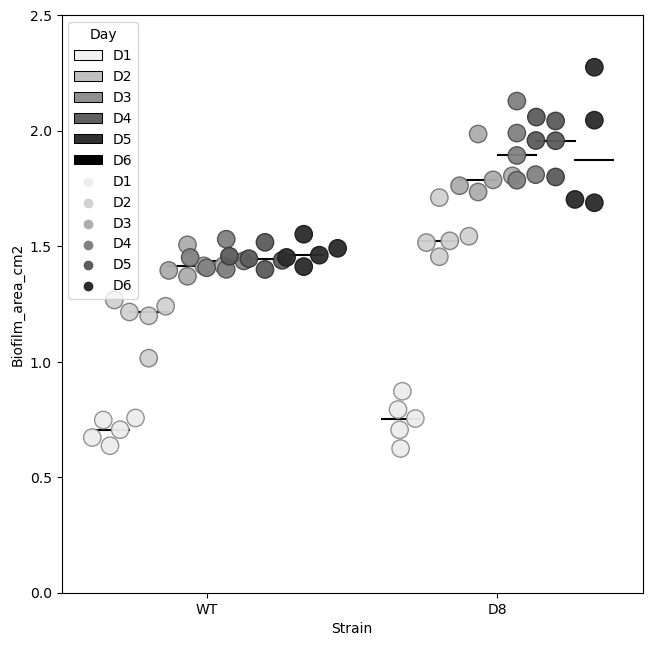

In [10]:
#VISUALISATION OF BIOFILM AREA
WTD8_MSgg = dataset
fig, axs = plt.subplots(1, 1, figsize=(7.5,7.5))
                        
sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['WT','D8'], data= WTD8_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['WT','D8'], data= WTD8_MSgg, dodge=True, s=12.5,alpha=0.95, linewidth=1, palette='Greys')

plt.ylim(0,2.5)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_MSgg.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_MSgg.svg", dpi = 300)
plt.show()

In [11]:
#STATISTICAL ANALYSIS
#ANOVA test
res = stat()
res.anova_stat(df=WTD8_MSgg, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Strain)')
res.anova_summary

df    sum_sq   mean_sq          F    PR(>F)
C(Strain)   1.0  1.961710  1.961710  13.567321  0.000513
Residual   57.0  8.241677  0.144591        NaN       NaN

In [12]:
#Multiple pairwise comparison
res.tukey_hsd(df=WTD8_MSgg, res_var='Biofilm_area_cm2', xfac_var=['Strain','Day'], anova_model='Biofilm_area_cm2 ~ C(Strain) + C(Day) + C(Strain):C(Day)')
df = res.tukey_summary
df.to_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\FootprintArea_MSgg_stat.csv")

C:\ProgramData\anaconda3\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]
C:\ProgramData\anaconda3\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]
C:\ProgramData\anaconda3\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, s

In [77]:
#T-test
WTD8_MSgg_biofilm_area_WT = WTD8_MSgg[WTD8_MSgg['Strain'] == 'WT']
WTD8_MSgg_biofilm_area_D8 = WTD8_MSgg[WTD8_MSgg['Strain'] == 'D8']
rvs1 = WTD8_MSgg_biofilm_area_WT['Biofilm_area_cm2']
rvs2 = WTD8_MSgg_biofilm_area_D8['Biofilm_area_cm2']

stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=-3.6833845101364138, pvalue=0.0005134923980961742)

## Comparison of monoproducers, single deletion and suite of deletion

In [13]:
#IMPORT IMAGES
image_name_list = [f for f in listdir(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_ProteaseMutants') if isfile(join(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_ProteaseMutants', f))]
image_list = []
for filename in glob.glob(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_ProteaseMutants\*.JPG'):
    im=Image.open(filename)
    image_list.append(im)

#CROP IMAGES
image_crop_list = []
for i in image_list:
    width, height = i.size
    
    left = width/5
    top = height / 8
    right = (width/5)*4
    bottom = (height/8)*7
    
    image_crop = i.crop((left, top, right, bottom))
    image_crop_list.append(image_crop)

#CONVERT IMAGES TO GRAYSCALE
image_gray_list =[]
for i in image_crop_list:
    image_gray = i.convert('L')
    image_gray_list.append(image_gray)
    
#EXTRACT MATRIX FROM IMAGE
image_matrix_list = []
for i in image_gray_list:
    image_matrix = np.asarray(i)
    image_matrix_list.append(image_matrix)

#CREATING A DATASET
image_dataset = pd.DataFrame()
image_dataset['Name'] = image_name_list
image_dataset['Pixel_value'] = image_matrix_list
image_dataset.head()

Name                                        Pixel_value
0  D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...
1  D1_D2.JPG  [[23, 26, 30, 37, 40, 39, 36, 35, 33, 29, 27, ...
2  D1_D3.JPG  [[34, 36, 37, 35, 35, 33, 31, 28, 27, 26, 25, ...
3  D1_D4.JPG  [[25, 27, 28, 28, 28, 25, 23, 24, 26, 24, 21, ...
4  D1_D5.JPG  [[21, 21, 22, 23, 27, 26, 26, 27, 27, 25, 23, ...

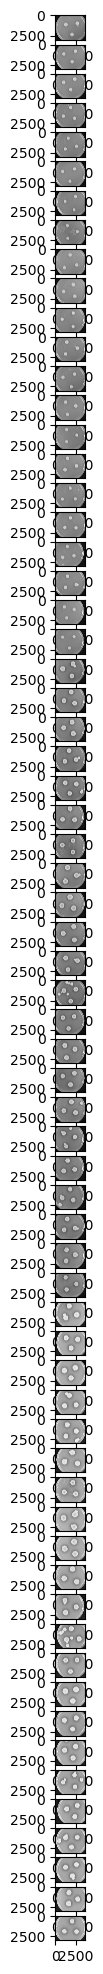

In [14]:
#DATASET VISUALISATION
fig, axs = plt.subplots(ncols=1, nrows=len(image_dataset['Name']), figsize=(15,25))

for i in range(len(image_dataset['Name'])):    
    axs[i].imshow(image_dataset.loc[i,'Pixel_value'], cmap=plt.cm.gray)

plt.show()

In [15]:
#GROUPING DATA BY MEDIA AND MIXING CONDITIONS

day = []
for index, rows in image_dataset.iterrows():
    Img_name = image_dataset.loc[index,'Name']
    if 'D1_' in Img_name:
        day.append('D1')
    elif 'D2_' in Img_name:
        day.append('D2')
    elif 'D3_' in Img_name:
        day.append('D3')    
image_dataset['Day'] = day

collection = []
for index, rows in image_dataset.iterrows():
    Img_name = image_dataset.loc[index,'Name']
    if '_D7' in Img_name:
        collection.append('Monoproducer')
    elif '_DaprE' in Img_name:
        collection.append('Single_deletion')
    elif '_Dbpr' in Img_name:
        collection.append('Single_deletion')
    elif '_Depr'in Img_name:
        collection.append('Single_deletion')
    elif '_Dmpr'in Img_name:
        collection.append('Single_deletion')
    elif '_DnprB'in Img_name:
        collection.append('Single_deletion')
    elif '_DnprE'in Img_name:
        collection.append('Single_deletion')
    elif '_Dvpr' in Img_name:
        collection.append('Single_deletion')
    elif '_DwprA' in Img_name:
        collection.append('Single_deletion')
    else:
        collection.append('Suite_deletion')
        
image_dataset['Collection'] = collection


image_dataset.head(20)

Name                                        Pixel_value Day  \
0        D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...  D1   
1        D1_D2.JPG  [[23, 26, 30, 37, 40, 39, 36, 35, 33, 29, 27, ...  D1   
2        D1_D3.JPG  [[34, 36, 37, 35, 35, 33, 31, 28, 27, 26, 25, ...  D1   
3        D1_D4.JPG  [[25, 27, 28, 28, 28, 25, 23, 24, 26, 24, 21, ...  D1   
4        D1_D5.JPG  [[21, 21, 22, 23, 27, 26, 26, 27, 27, 25, 23, ...  D1   
5        D1_D6.JPG  [[18, 17, 16, 15, 16, 16, 17, 20, 22, 24, 25, ...  D1   
6   D1_D7- vpr.JPG  [[24, 25, 28, 35, 43, 43, 37, 29, 24, 27, 39, ...  D1   
7   D1_D7-aprE.JPG  [[33, 34, 36, 38, 36, 31, 27, 24, 23, 22, 20, ...  D1   
8    D1_D7-bpr.JPG  [[24, 23, 22, 21, 17, 19, 23, 25, 25, 24, 22, ...  D1   
9    D1_D7-epr.JPG  [[26, 26, 26, 27, 27, 26, 27, 27, 29, 32, 33, ...  D1   
10   D1_D7-mpr.JPG  [[24, 24, 24, 26, 28, 29, 32, 36, 36, 34, 34, ...  D1   
11  D1_D7-nprB.JPG  [[27, 29, 31, 34, 35, 34, 33, 32, 31, 31, 31, ...  D1   
12  D1_D7-nprE.JPG  [[27, 31, 33, 34, 34, 33, 30, 31, 33, 37, 38, ...  D1   
13  D1_D7-wprA.JPG  [[31, 28, 25, 23, 22, 21, 21, 20, 18, 16, 16, ...  D1   
14    D1_DaprE.JPG  [[23, 23, 22, 23, 24, 24, 24, 23, 20, 17, 17, ...  D1   
15     D1_Dbpr.JPG  [[20, 23, 23, 22, 23, 24, 23, 26, 28, 29, 30, ...  D1   
16     D1_Depr.JPG  [[20, 17, 16, 17, 18, 20, 23, 26, 26, 25, 24, ...  D1   
17     D1_Dmpr.JPG  [[23, 22, 18, 16, 18, 21, 22, 24, 27, 28, 26, ...  D1   
18    D1_DnprB.JPG  [[19, 19, 19, 19, 18, 17, 16, 16, 17, 18, 18, ...  D1   
19    D1_DnprE.JPG  [[24, 24, 22, 22, 20, 18, 19, 21, 22, 21, 20, ...  D1   

         Collection  
0    Suite_deletion  
1    Suite_deletion  
2    Suite_deletion  
3    Suite_deletion  
4    Suite_deletion  
5    Suite_deletion  
6      Monoproducer  
7      Monoproducer  
8      Monoproducer  
9      Monoproducer  
10     Monoproducer  
11     Monoproducer  
12     Monoproducer  
13     Monoproducer  
14  Single_deletion  
15  Single_deletion  
16  Single_deletion  
17  Single_deletion  
18  Single_deletion  
19  Single_deletion

In [16]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

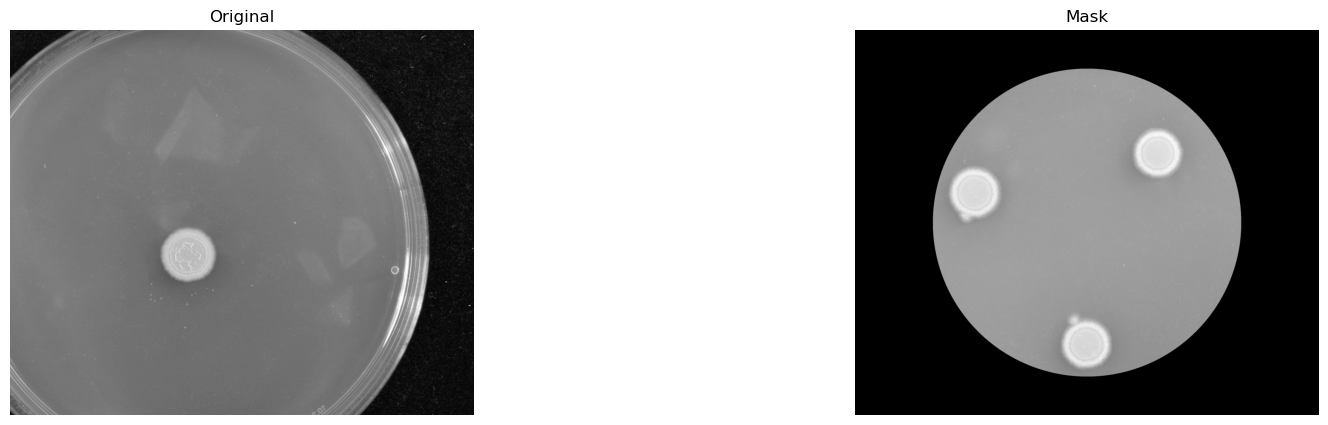

In [17]:
img = image_dataset.loc[5,'Pixel_value']

h, w = img.shape[:2]
mask = create_circular_mask(h, w,radius = h/2.5)
masked_img = img.copy()
masked_img[~mask] = 0

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# Plotting the original image.
ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')


    
ax[1].imshow(masked_img, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

    
plt.subplots_adjust()
plt.show()

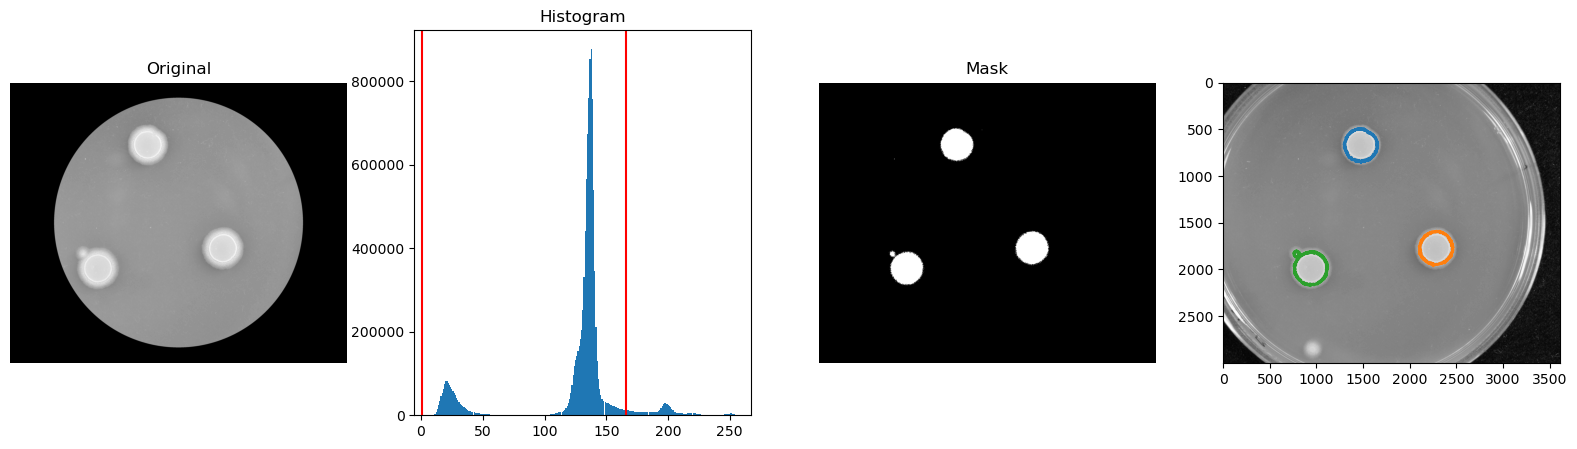

CPU times: total: 2.33 s
Wall time: 3.7 s


In [18]:
%%time
#APPLYING A CIRCULAR MASK TO REMOVE PETRI DISH BORDER
img = image_dataset.loc[18,'Pixel_value']

h, w = img.shape[:2]
mask = create_circular_mask(h, w, radius = h/2.25)
masked_img = img.copy()
masked_img[~mask] = 0

#FINDING BIOFILM EDGE
Threshold_multiotsu = skm.filters.threshold_multiotsu(masked_img, classes=3)
Img_test_mask = masked_img > (Threshold_multiotsu[1]+25)
Img_test_fill = sc.ndimage.binary_fill_holes(Img_test_mask)

mask = Img_test_fill

Img_test_contours = skm.measure.find_contours(mask, level=False, fully_connected='high', positive_orientation='high')
Img_test_contours_clean = [a for a in Img_test_contours if len(a) > 1500]


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
# Plotting the original image.
ax[0].imshow(masked_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(img.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in Threshold_multiotsu:
    ax[1].axvline(thresh, color='r')
    
ax[2].imshow(Img_test_fill, cmap='gray')
ax[2].set_title('Mask')
ax[2].axis('off')

ax[3].imshow(img, cmap=plt.cm.gray)
for contour in Img_test_contours_clean:  
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    
plt.subplots_adjust()
plt.show()

In [19]:
%%time
dataset = image_dataset

Biofilm_contour =[]

for index, rows in dataset.iterrows():
    Biofilm_image = dataset.loc[index,'Pixel_value']
    
    #Create a circular mask to remove petri dish border
    h, w = Biofilm_image.shape[:2]
    mask = create_circular_mask(h, w, radius=h/2.25)
    masked_img = Biofilm_image.copy()
    masked_img[~mask] = 0
    
    #Dividing histogram signal into three classes
    Threshold_multiotsu = skm.filters.threshold_multiotsu(Biofilm_image, classes=3)
    
    #Removing background signal in the mask
    Img_mask = masked_img > (Threshold_multiotsu[1]+25) 
    
    #Filling holes in the mask
    Img_fill = sc.ndimage.binary_fill_holes(Img_mask)
        
    #Finding biofilm image
    Img_contours = skm.measure.find_contours(Img_fill, level=False, fully_connected='high', positive_orientation='high')
    
    #Keeping only big contours
    Img_contours_clean = [a for a in Img_contours if len(a) > 1250]
    
    Biofilm_contour.append(Img_contours_clean)

dataset['Biofilm_contour'] = Biofilm_contour

dataset.head()

CPU times: total: 40.2 s
Wall time: 50 s


Name                                        Pixel_value Day  \
0  D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...  D1   
1  D1_D2.JPG  [[23, 26, 30, 37, 40, 39, 36, 35, 33, 29, 27, ...  D1   
2  D1_D3.JPG  [[34, 36, 37, 35, 35, 33, 31, 28, 27, 26, 25, ...  D1   
3  D1_D4.JPG  [[25, 27, 28, 28, 28, 25, 23, 24, 26, 24, 21, ...  D1   
4  D1_D5.JPG  [[21, 21, 22, 23, 27, 26, 26, 27, 27, 25, 23, ...  D1   

       Collection                                    Biofilm_contour  
0  Suite_deletion  [[[1215.0, 2694.0], [1214.0, 2695.0], [1213.0,...  
1  Suite_deletion  [[[1063.0, 2453.0], [1062.0, 2454.0], [1061.0,...  
2  Suite_deletion  [[[945.0, 2388.0], [944.0, 2389.0], [943.0, 23...  
3  Suite_deletion  [[[855.0, 1904.0], [854.0, 1905.0], [853.0, 19...  
4  Suite_deletion  [[[938.0, 1596.0], [937.0, 1597.0], [936.0, 15...

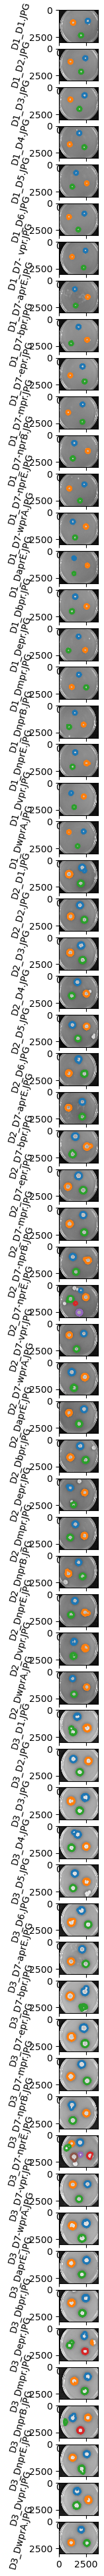

In [20]:
#CONTOUR VISUALISATION

fig, axs = plt.subplots(ncols=1, nrows=len(dataset['Name']), figsize=(5,50))

for i in range(len(dataset['Name'])):    
    axs[i].imshow(dataset.loc[i,'Pixel_value'], cmap=plt.cm.gray)
    axs[i].set_ylabel(dataset.loc[i,'Name'], rotation=75)
        
        
    for contour in dataset.loc[i,'Biofilm_contour']:
        axs[i].plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

In [21]:
%%time
Biofilm1 = []
Biofilm2 = []
Biofilm3 = []

for index, rows in dataset.iterrows():
    Img_name = dataset.loc[index,'Name']
    Biofilms = dataset.loc[index,'Biofilm_contour']
    if Img_name == 'D3_D7-nprE.JPG':
        Biofilm1.append(Biofilms[0])
        Biofilm2.append(Biofilms[3])
        Biofilm3.append(Biofilms[5])
        
    elif Img_name == 'D2_D7-nprE.JPG':
        Biofilm1.append(Biofilms[4])
        Biofilm2.append(Biofilms[1])
        Biofilm3.append(Biofilms[2])
        
    elif Img_name == 'D3_Depr.JPG':
        Biofilm1.append(Biofilms[0])
        Biofilm2.append(Biofilms[3])
        Biofilm3.append(Biofilms[2])
        
    elif Img_name == 'D3_DnprB.JPG':
        Biofilm1.append(Biofilms[0])
        Biofilm2.append(Biofilms[1])
        Biofilm3.append(Biofilms[3])
    
    else:
        Biofilm1.append(Biofilms[0])
        Biofilm2.append(Biofilms[1])
        Biofilm3.append(Biofilms[2])
    
dataset['Biofilm_1'] = Biofilm1
dataset['Biofilm_2'] = Biofilm2
dataset['Biofilm_3'] = Biofilm3

dataset.head()

CPU times: total: 0 ns
Wall time: 6.94 ms


Name                                        Pixel_value Day  \
0  D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...  D1   
1  D1_D2.JPG  [[23, 26, 30, 37, 40, 39, 36, 35, 33, 29, 27, ...  D1   
2  D1_D3.JPG  [[34, 36, 37, 35, 35, 33, 31, 28, 27, 26, 25, ...  D1   
3  D1_D4.JPG  [[25, 27, 28, 28, 28, 25, 23, 24, 26, 24, 21, ...  D1   
4  D1_D5.JPG  [[21, 21, 22, 23, 27, 26, 26, 27, 27, 25, 23, ...  D1   

       Collection                                    Biofilm_contour  \
0  Suite_deletion  [[[1215.0, 2694.0], [1214.0, 2695.0], [1213.0,...   
1  Suite_deletion  [[[1063.0, 2453.0], [1062.0, 2454.0], [1061.0,...   
2  Suite_deletion  [[[945.0, 2388.0], [944.0, 2389.0], [943.0, 23...   
3  Suite_deletion  [[[855.0, 1904.0], [854.0, 1905.0], [853.0, 19...   
4  Suite_deletion  [[[938.0, 1596.0], [937.0, 1597.0], [936.0, 15...   

                                           Biofilm_1  \
0  [[1215.0, 2694.0], [1214.0, 2695.0], [1213.0, ...   
1  [[1063.0, 2453.0], [1062.0, 2454.0], [1061.0, ...   
2  [[945.0, 2388.0], [944.0, 2389.0], [943.0, 239...   
3  [[855.0, 1904.0], [854.0, 1905.0], [853.0, 190...   
4  [[938.0, 1596.0], [937.0, 1597.0], [936.0, 159...   

                                           Biofilm_2  \
0  [[1363.0, 1336.0], [1362.0, 1337.0], [1361.0, ...   
1  [[1390.0, 1067.0], [1389.0, 1068.0], [1388.0, ...   
2  [[1324.0, 1072.0], [1323.0, 1073.0], [1322.0, ...   
3  [[1896.0, 1008.0], [1895.0, 1009.0], [1894.0, ...   
4  [[1907.0, 2563.0], [1906.0, 2564.0], [1905.0, ...   

                                           Biofilm_3  
0  [[2545.0, 2020.0], [2544.0, 2021.0], [2543.0, ...  
1  [[2325.0, 2060.0], [2324.0, 2061.0], [2323.0, ...  
2  [[2191.0, 1915.0], [2190.0, 1916.0], [2189.0, ...  
3  [[2156.0, 2353.0], [2155.0, 2354.0], [2154.0, ...  
4  [[2225.0, 1246.0], [2224.0, 1247.0], [2223.0, ...

In [22]:
#SCALE (1cm = 400pixels)
cm = 400
cm2 = cm*cm

#BIOFILM QUANTIFICATION
mask_filled1 = []
mask_filled2 = []
mask_filled3 = []
biofilm_area = []



for index, rows in dataset.iterrows():
    Biofilm_image = dataset.loc[index,'Pixel_value']
    contour1 = dataset.loc[index,'Biofilm_1']
    contour2 = dataset.loc[index,'Biofilm_2']
    contour3 = dataset.loc[index,'Biofilm_3']
    mask1 = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)
    mask2 = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)
    mask3 = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)

    for i in contour1:
        x_pixel = int(i[0])
        y_pixel = int(i[1])
        mask1[x_pixel,y_pixel] = 1
    for i in contour2:
        x_pixel = int(i[0])
        y_pixel = int(i[1])
        mask2[x_pixel,y_pixel] = 1
    for i in contour3:
        x_pixel = int(i[0])
        y_pixel = int(i[1])
        mask3[x_pixel,y_pixel] = 1
            
    mask_f1 = sc.ndimage.binary_fill_holes(mask1)
    mask_f2 = sc.ndimage.binary_fill_holes(mask2)
    mask_f3 = sc.ndimage.binary_fill_holes(mask3)
    mask_filled1.append(mask_f1.astype(np.uint8))
    mask_filled2.append(mask_f1.astype(np.uint8))
    mask_filled3.append(mask_f1.astype(np.uint8))

    #Measuring area
    props1 = skm.measure.regionprops_table(mask_f1.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    props2 = skm.measure.regionprops_table(mask_f2.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    props3 = skm.measure.regionprops_table(mask_f3.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    biofilm_area.append((props1['area'][0])/cm2)
    biofilm_area.append((props2['area'][0])/cm2)
    biofilm_area.append((props3['area'][0])/cm2)

dataset = dataset.loc[dataset.index.repeat(3)].reset_index(drop=True)    
dataset['Biofilm_area_cm2'] = biofilm_area
dataset.head()

Name                                        Pixel_value Day  \
0  D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...  D1   
1  D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...  D1   
2  D1_D1.JPG  [[34, 30, 29, 28, 29, 28, 26, 25, 27, 28, 29, ...  D1   
3  D1_D2.JPG  [[23, 26, 30, 37, 40, 39, 36, 35, 33, 29, 27, ...  D1   
4  D1_D2.JPG  [[23, 26, 30, 37, 40, 39, 36, 35, 33, 29, 27, ...  D1   

       Collection                                    Biofilm_contour  \
0  Suite_deletion  [[[1215.0, 2694.0], [1214.0, 2695.0], [1213.0,...   
1  Suite_deletion  [[[1215.0, 2694.0], [1214.0, 2695.0], [1213.0,...   
2  Suite_deletion  [[[1215.0, 2694.0], [1214.0, 2695.0], [1213.0,...   
3  Suite_deletion  [[[1063.0, 2453.0], [1062.0, 2454.0], [1061.0,...   
4  Suite_deletion  [[[1063.0, 2453.0], [1062.0, 2454.0], [1061.0,...   

                                           Biofilm_1  \
0  [[1215.0, 2694.0], [1214.0, 2695.0], [1213.0, ...   
1  [[1215.0, 2694.0], [1214.0, 2695.0], [1213.0, ...   
2  [[1215.0, 2694.0], [1214.0, 2695.0], [1213.0, ...   
3  [[1063.0, 2453.0], [1062.0, 2454.0], [1061.0, ...   
4  [[1063.0, 2453.0], [1062.0, 2454.0], [1061.0, ...   

                                           Biofilm_2  \
0  [[1363.0, 1336.0], [1362.0, 1337.0], [1361.0, ...   
1  [[1363.0, 1336.0], [1362.0, 1337.0], [1361.0, ...   
2  [[1363.0, 1336.0], [1362.0, 1337.0], [1361.0, ...   
3  [[1390.0, 1067.0], [1389.0, 1068.0], [1388.0, ...   
4  [[1390.0, 1067.0], [1389.0, 1068.0], [1388.0, ...   

                                           Biofilm_3  Biofilm_area_cm2  
0  [[2545.0, 2020.0], [2544.0, 2021.0], [2543.0, ...          0.810963  
1  [[2545.0, 2020.0], [2544.0, 2021.0], [2543.0, ...          0.811869  
2  [[2545.0, 2020.0], [2544.0, 2021.0], [2543.0, ...          0.728050  
3  [[2325.0, 2060.0], [2324.0, 2061.0], [2323.0, ...          0.690819  
4  [[2325.0, 2060.0], [2324.0, 2061.0], [2323.0, ...          0.673119

In [23]:
monoproducer = dataset[dataset['Collection'] == 'Monoproducer']
strain = []
for index, row in monoproducer.iterrows():
    Img_name = monoproducer.loc[index,'Name']
    if 'aprE' in Img_name:
        strain.append('D7-aprE')
    elif 'bpr' in Img_name:
        strain.append('D7-bpr')
    elif 'epr' in Img_name:
        strain.append('D7-epr') 
    elif 'mpr' in Img_name:
        strain.append('D7-mpr')        
    elif 'nprB' in Img_name:
        strain.append('D7-nprB')        
    elif 'nprE' in Img_name:
        strain.append('D7-nprE') 
    elif 'vpr' in Img_name:
        strain.append('D7-vpr')        
    elif 'wprA' in Img_name:
        strain.append('D7-wprA')   
        
monoproducer['Strain'] = strain

WTD8_MSgg_D1D3 = WTD8_MSgg[(WTD8_MSgg['Day'] == 'D1')|(WTD8_MSgg['Day'] == 'D2')|(WTD8_MSgg['Day'] == 'D3')]

monoproducerall = pd.concat([WTD8_MSgg_D1D3, monoproducer])
monoproducerall.head()

C:\Users\Thibault Rosazza\AppData\Local\Temp\ipykernel_24112\418017728.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monoproducer['Strain'] = strain


Name                                        Pixel_value Day  \
0  D1_MSgg_D8_1.JPG  [[15, 16, 16, 17, 18, 18, 19, 19, 19, 20, 21, ...  D1   
1  D1_MSgg_D8_2.JPG  [[22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 17, ...  D1   
2  D1_MSgg_D8_3.JPG  [[22, 25, 26, 28, 31, 37, 44, 50, 53, 49, 41, ...  D1   
3  D1_MSgg_D8_4.JPG  [[27, 27, 26, 24, 23, 20, 17, 18, 21, 23, 23, ...  D1   
4  D1_MSgg_D8_5.JPG  [[27, 29, 28, 26, 25, 24, 21, 20, 19, 17, 17, ...  D1   

  Strain                                    Biofilm_contour  \
0     D8  [[[1638.0, 1866.0], [1637.0, 1867.0], [1636.0,...   
1     D8  [[[1761.0, 1776.0], [1760.0, 1777.0], [1760.0,...   
2     D8  [[[1645.0, 1733.0], [1644.0, 1734.0], [1644.0,...   
3     D8  [[[1851.0, 1658.0], [1850.0, 1659.0], [1849.0,...   
4     D8  [[[1714.0, 1720.0], [1713.0, 1721.0], [1713.0,...   

                                        Biofilm_mask  Biofilm_area_cm2  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.754150   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.872119   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.705269   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.624206   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          0.792969   

   Ra_index Collection Biofilm_1 Biofilm_2 Biofilm_3  
0    1850.0        NaN       NaN       NaN       NaN  
1    1775.0        NaN       NaN       NaN       NaN  
2    1754.0        NaN       NaN       NaN       NaN  
3    1636.0        NaN       NaN       NaN       NaN  
4    1727.0        NaN       NaN       NaN       NaN

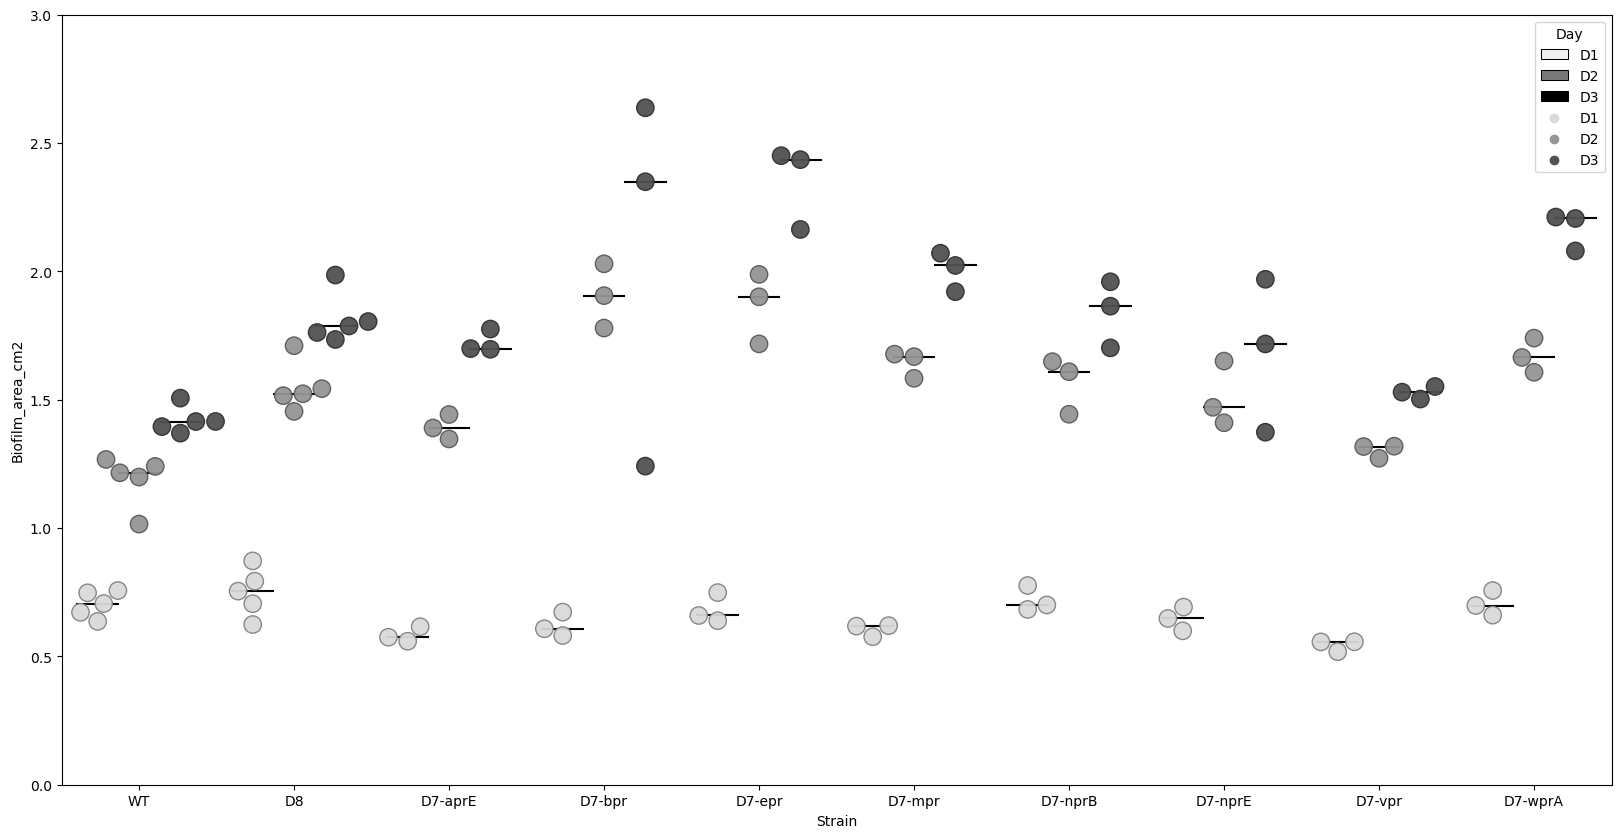

In [24]:
#VISUALISATION OF MONOPRODUCER BIOFILM AREA  
fig, axs = plt.subplots(1, 1, figsize=(20,10))
                        
sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= monoproducerall, order=['WT','D8','D7-aprE','D7-bpr','D7-epr','D7-mpr','D7-nprB','D7-nprE','D7-vpr','D7-wprA'], whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= monoproducerall, order=['WT','D8','D7-aprE','D7-bpr','D7-epr','D7-mpr','D7-nprB','D7-nprE','D7-vpr','D7-wprA'], dodge=True, s=12.5,alpha=0.95, linewidth=1, palette='Greys')

plt.ylim(0,3)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_Monoproducer.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_Monoproducer.svg", dpi = 300)
plt.show()

In [25]:
#STATISTICAL ANALYSIS
#ANOVA test
res = stat()
res.anova_stat(df=monoproducerall, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Strain)')
res.anova_summary

df     sum_sq   mean_sq         F    PR(>F)
C(Strain)   9.0   2.851806  0.316867  1.026277  0.425301
Residual   92.0  28.405376  0.308754       NaN       NaN

In [26]:
#Multiple pairwise comparison
#res.tukey_hsd(df=monoproducerall, res_var='Biofilm_area_cm2', xfac_var=['Strain','Day'], anova_model='Biofilm_area_cm2 ~ C(Strain) + C(Day) + C(Strain):C(Day)')
#res.tukey_summary

In [89]:
monoproducerall_WT['Day'] == 'D1'

5      True
6      True
7      True
8      True
9      True
15    False
16    False
17    False
18    False
19    False
25    False
26    False
27    False
28    False
29    False
Name: Day, dtype: bool

In [93]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D8 = monoproducerall[monoproducerall['Strain'] == 'D8']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D8[monoproducerall_D8['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D8[monoproducerall_D8['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D8[monoproducerall_D8['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=-0.9729420232951592, pvalue=0.35907766200789326)
Ttest_indResult(statistic=-5.8553326945508, pvalue=0.00038047167488100087)
Ttest_indResult(statistic=-7.899244502223849, pvalue=4.7834234133084776e-05)


In [94]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-aprE']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=3.689189591149623, pvalue=0.010218554590761163)
Ttest_indResult(statistic=-3.2824217812378316, pvalue=0.016771757191328323)
Ttest_indResult(statistic=-8.411794002550083, pvalue=0.00015384682940836853)


In [95]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-bpr']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=2.301114759841935, pvalue=0.06100717026675507)
Ttest_indResult(statistic=-9.031279137327752, pvalue=0.0001032321297676413)
Ttest_indResult(statistic=-2.0994181575427735, pvalue=0.0805424557261599)


In [96]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-epr']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=0.5474558988665674, pvalue=0.6038171458593882)
Ttest_indResult(statistic=-8.192158843988675, pvalue=0.0001783149873435106)
Ttest_indResult(statistic=-12.435773948060799, pvalue=1.6514003107936348e-05)


In [97]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-mpr']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=3.0935280587231477, pvalue=0.021291673912279093)
Ttest_indResult(statistic=-7.202193880070944, pvalue=0.00036271128264865377)
Ttest_indResult(statistic=-13.120186709546779, pvalue=1.2094493043759077e-05)


In [98]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-nprB']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=-0.4414665945018693, pvalue=0.6743399565886316)
Ttest_indResult(statistic=-5.060001408194211, pvalue=0.0023106780373462576)
Ttest_indResult(statistic=-6.703544366481456, pvalue=0.0005350265831247382)


In [99]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-nprE']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=1.5885027759649302, pvalue=0.16327258672949152)
Ttest_indResult(statistic=-4.068093206157947, pvalue=0.006589992172520788)
Ttest_indResult(statistic=-2.0516797589146107, pvalue=0.0860417124232693)


In [100]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-vpr']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=5.043663070678574, pvalue=0.002348311072264477)
Ttest_indResult(statistic=-1.9097405197017663, pvalue=0.10474559689234048)
Ttest_indResult(statistic=-3.3184011166843703, pvalue=0.016036216630365138)


In [101]:
#T-test
monoproducerall_WT = monoproducerall[monoproducerall['Strain'] == 'WT']
monoproducerall_D = monoproducerall[monoproducerall['Strain'] == 'D7-wprA']

rvs1 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D1']
rvs1 = rvs1['Biofilm_area_cm2']
rvs2 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D2']
rvs2 = rvs2['Biofilm_area_cm2']
rvs3 = monoproducerall_WT[monoproducerall_WT['Day'] == 'D3']
rvs3 = rvs3['Biofilm_area_cm2']
                          
rvs4 = monoproducerall_D[monoproducerall_D['Day'] == 'D1']
rvs4 = rvs4['Biofilm_area_cm2']
rvs5 = monoproducerall_D[monoproducerall_D['Day'] == 'D2']
rvs5 = rvs5['Biofilm_area_cm2']
rvs6 = monoproducerall_D[monoproducerall_D['Day'] == 'D3']
rvs6 = rvs6['Biofilm_area_cm2']

print(stats.ttest_ind(rvs1, rvs4))
print(stats.ttest_ind(rvs2, rvs5))
print(stats.ttest_ind(rvs3, rvs6))

Ttest_indResult(statistic=-0.041640080568616976, pvalue=0.9681366950822504)
Ttest_indResult(statistic=-7.353703793121631, pvalue=0.00032371043125256475)
Ttest_indResult(statistic=-16.961273687488433, pvalue=2.685436988412099e-06)


In [27]:
singledeletion = dataset[dataset['Collection'] == 'Single_deletion']
strain = []
for index, row in singledeletion.iterrows():
    Img_name = singledeletion.loc[index,'Name']
    if 'DaprE' in Img_name:
        strain.append('DaprE')
    elif 'Dbpr' in Img_name:
        strain.append('Dbpr')
    elif 'Depr' in Img_name:
        strain.append('Depr') 
    elif 'Dmpr' in Img_name:
        strain.append('Dmpr')        
    elif 'DnprB' in Img_name:
        strain.append('DnprB')        
    elif 'DnprE' in Img_name:
        strain.append('DnprE') 
    elif 'Dvpr' in Img_name:
        strain.append('Dvpr')        
    elif 'DwprA' in Img_name:
        strain.append('DwprA')   
        
singledeletion['Strain'] = strain

WTD8_MSgg_D1D3 = WTD8_MSgg[(WTD8_MSgg['Day'] == 'D1')|(WTD8_MSgg['Day'] == 'D2')|(WTD8_MSgg['Day'] == 'D3')]

singledeletionall = pd.concat([WTD8_MSgg_D1D3, singledeletion])
singledeletionall.tail()

C:\Users\Thibault Rosazza\AppData\Local\Temp\ipykernel_24112\2697650750.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singledeletion['Strain'] = strain


Name                                        Pixel_value Day  \
193   D3_Dvpr.JPG  [[34, 37, 42, 47, 48, 40, 32, 29, 31, 35, 38, ...  D3   
194   D3_Dvpr.JPG  [[34, 37, 42, 47, 48, 40, 32, 29, 31, 35, 38, ...  D3   
195  D3_DwprA.JPG  [[48, 55, 51, 48, 44, 38, 34, 37, 47, 62, 63, ...  D3   
196  D3_DwprA.JPG  [[48, 55, 51, 48, 44, 38, 34, 37, 47, 62, 63, ...  D3   
197  D3_DwprA.JPG  [[48, 55, 51, 48, 44, 38, 34, 37, 47, 62, 63, ...  D3   

    Strain                                    Biofilm_contour Biofilm_mask  \
193   Dvpr  [[[1076.0, 1776.0], [1075.0, 1777.0], [1075.0,...          NaN   
194   Dvpr  [[[1076.0, 1776.0], [1075.0, 1777.0], [1075.0,...          NaN   
195  DwprA  [[[1026.0, 2113.0], [1025.0, 2114.0], [1024.0,...          NaN   
196  DwprA  [[[1026.0, 2113.0], [1025.0, 2114.0], [1024.0,...          NaN   
197  DwprA  [[[1026.0, 2113.0], [1025.0, 2114.0], [1024.0,...          NaN   

     Biofilm_area_cm2  Ra_index       Collection  \
193          1.690225       NaN  Single_deletion   
194          1.944287       NaN  Single_deletion   
195          1.346113       NaN  Single_deletion   
196          1.309331       NaN  Single_deletion   
197          1.368537       NaN  Single_deletion   

                                             Biofilm_1  \
193  [[1076.0, 1776.0], [1075.0, 1777.0], [1075.0, ...   
194  [[1076.0, 1776.0], [1075.0, 1777.0], [1075.0, ...   
195  [[1026.0, 2113.0], [1025.0, 2114.0], [1024.0, ...   
196  [[1026.0, 2113.0], [1025.0, 2114.0], [1024.0, ...   
197  [[1026.0, 2113.0], [1025.0, 2114.0], [1024.0, ...   

                                             Biofilm_2  \
193  [[1898.0, 2782.0], [1897.0, 2783.0], [1897.0, ...   
194  [[1898.0, 2782.0], [1897.0, 2783.0], [1897.0, ...   
195  [[2226.0, 1184.0], [2225.0, 1185.0], [2225.0, ...   
196  [[2226.0, 1184.0], [2225.0, 1185.0], [2225.0, ...   
197  [[2226.0, 1184.0], [2225.0, 1185.0], [2225.0, ...   

                                             Biofilm_3  
193  [[2420.0, 1570.0], [2419.0, 1571.0], [2418.0, ...  
194  [[2420.0, 1570.0], [2419.0, 1571.0], [2418.0, ...  
195  [[2286.0, 2590.0], [2285.0, 2591.0], [2285.0, ...  
196  [[2286.0, 2590.0], [2285.0, 2591.0], [2285.0, ...  
197  [[2286.0, 2590.0], [2285.0, 2591.0], [2285.0, ...

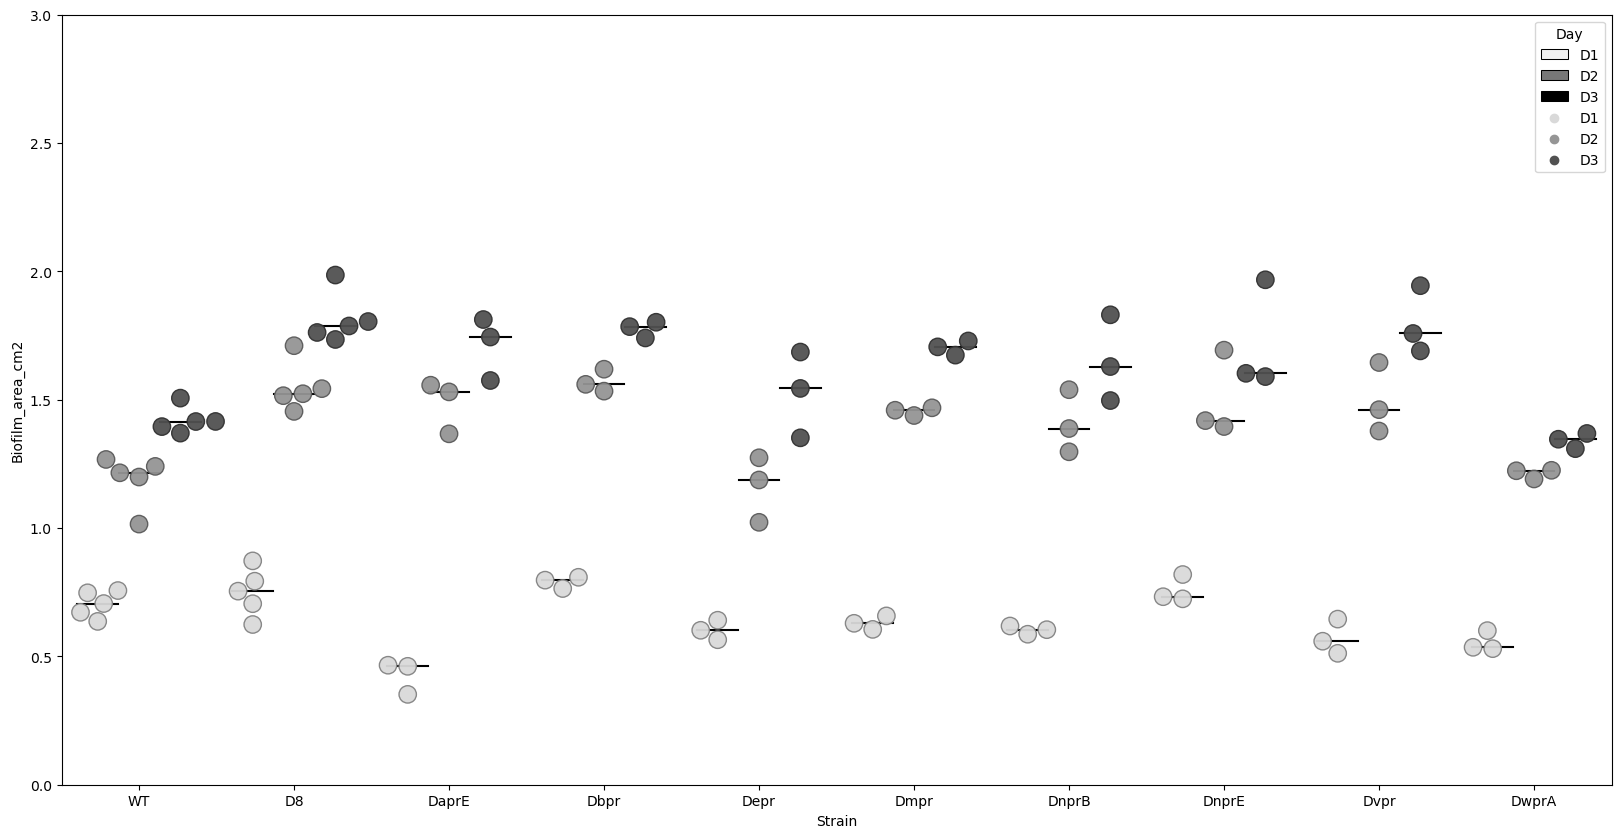

In [28]:
#VISUALISATION OF SINGLE DELETION BIOFILM AREA    
fig, axs = plt.subplots(1, 1, figsize=(20,10))
                        
sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= singledeletionall, order=['WT','D8','DaprE','Dbpr','Depr','Dmpr','DnprB','DnprE','Dvpr','DwprA'], whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= singledeletionall, order=['WT','D8','DaprE','Dbpr','Depr','Dmpr','DnprB','DnprE','Dvpr','DwprA'], dodge=True, s=12.5,alpha=0.95, linewidth=1, palette='Greys')

plt.ylim(0,3)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_Singledeletion.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_Singledeletion.svg", dpi = 300)
plt.show()

In [29]:
#STATISTICAL ANALYSIS
#ANOVA test
res = stat()
res.anova_stat(df=singledeletionall, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Strain)')
res.anova_summary

df     sum_sq   mean_sq         F    PR(>F)
C(Strain)   9.0   1.364177  0.151575  0.713244  0.695445
Residual   92.0  19.551389  0.212515       NaN       NaN

In [30]:
suitedeletion = dataset[dataset['Collection'] == 'Suite_deletion']

strain = []
for index, row in suitedeletion.iterrows():
    Img_name = suitedeletion.loc[index,'Name']
    if '_D1' in Img_name:
        strain.append('D1')
    elif '_D2' in Img_name:
        strain.append('D2')
    elif '_D3' in Img_name:
        strain.append('D3') 
    elif '_D4' in Img_name:
        strain.append('D4')        
    elif '_D5' in Img_name:
        strain.append('D5')        
    elif '_D6' in Img_name:
        strain.append('D6') 

suitedeletion['Strain'] = strain

WTD8_MSgg_D1D3 = WTD8_MSgg[(WTD8_MSgg['Day'] == 'D1')|(WTD8_MSgg['Day'] == 'D2')|(WTD8_MSgg['Day'] == 'D3')]
D7_MSgg = monoproducer[monoproducer['Strain'] == 'D7-wprA']

suitedeletionall = pd.concat([WTD8_MSgg_D1D3, suitedeletion, D7_MSgg])
suitedeletionall.tail()

C:\Users\Thibault Rosazza\AppData\Local\Temp\ipykernel_24112\851155937.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suitedeletion['Strain'] = strain


Name                                        Pixel_value Day  \
106  D2_D7-wprA.JPG  [[20, 22, 24, 24, 24, 25, 27, 29, 28, 25, 22, ...  D2   
107  D2_D7-wprA.JPG  [[20, 22, 24, 24, 24, 25, 27, 29, 28, 25, 22, ...  D2   
171  D3_D7-wprA.JPG  [[46, 40, 35, 35, 38, 37, 35, 34, 33, 32, 29, ...  D3   
172  D3_D7-wprA.JPG  [[46, 40, 35, 35, 38, 37, 35, 34, 33, 32, 29, ...  D3   
173  D3_D7-wprA.JPG  [[46, 40, 35, 35, 38, 37, 35, 34, 33, 32, 29, ...  D3   

      Strain                                    Biofilm_contour Biofilm_mask  \
106  D7-wprA  [[[1206.0, 1169.0], [1205.0, 1170.0], [1204.0,...          NaN   
107  D7-wprA  [[[1206.0, 1169.0], [1205.0, 1170.0], [1204.0,...          NaN   
171  D7-wprA  [[[1371.0, 2560.0], [1370.0, 2561.0], [1370.0,...          NaN   
172  D7-wprA  [[[1371.0, 2560.0], [1370.0, 2561.0], [1370.0,...          NaN   
173  D7-wprA  [[[1371.0, 2560.0], [1370.0, 2561.0], [1370.0,...          NaN   

     Biofilm_area_cm2  Ra_index    Collection  \
106          1.739988       NaN  Monoproducer   
107          1.606912       NaN  Monoproducer   
171          2.211656       NaN  Monoproducer   
172          2.206088       NaN  Monoproducer   
173          2.079769       NaN  Monoproducer   

                                             Biofilm_1  \
106  [[1206.0, 1169.0], [1205.0, 1170.0], [1204.0, ...   
107  [[1206.0, 1169.0], [1205.0, 1170.0], [1204.0, ...   
171  [[1371.0, 2560.0], [1370.0, 2561.0], [1370.0, ...   
172  [[1371.0, 2560.0], [1370.0, 2561.0], [1370.0, ...   
173  [[1371.0, 2560.0], [1370.0, 2561.0], [1370.0, ...   

                                             Biofilm_2  \
106  [[1670.0, 2417.0], [1669.0, 2418.0], [1668.0, ...   
107  [[1670.0, 2417.0], [1669.0, 2418.0], [1668.0, ...   
171  [[1579.0, 1298.0], [1578.0, 1299.0], [1577.0, ...   
172  [[1579.0, 1298.0], [1578.0, 1299.0], [1577.0, ...   
173  [[1579.0, 1298.0], [1578.0, 1299.0], [1577.0, ...   

                                             Biofilm_3  
106  [[2666.0, 1410.0], [2665.0, 1411.0], [2664.0, ...  
107  [[2666.0, 1410.0], [2665.0, 1411.0], [2664.0, ...  
171  [[2733.0, 2116.0], [2732.0, 2117.0], [2732.0, ...  
172  [[2733.0, 2116.0], [2732.0, 2117.0], [2732.0, ...  
173  [[2733.0, 2116.0], [2732.0, 2117.0], [2732.0, ...

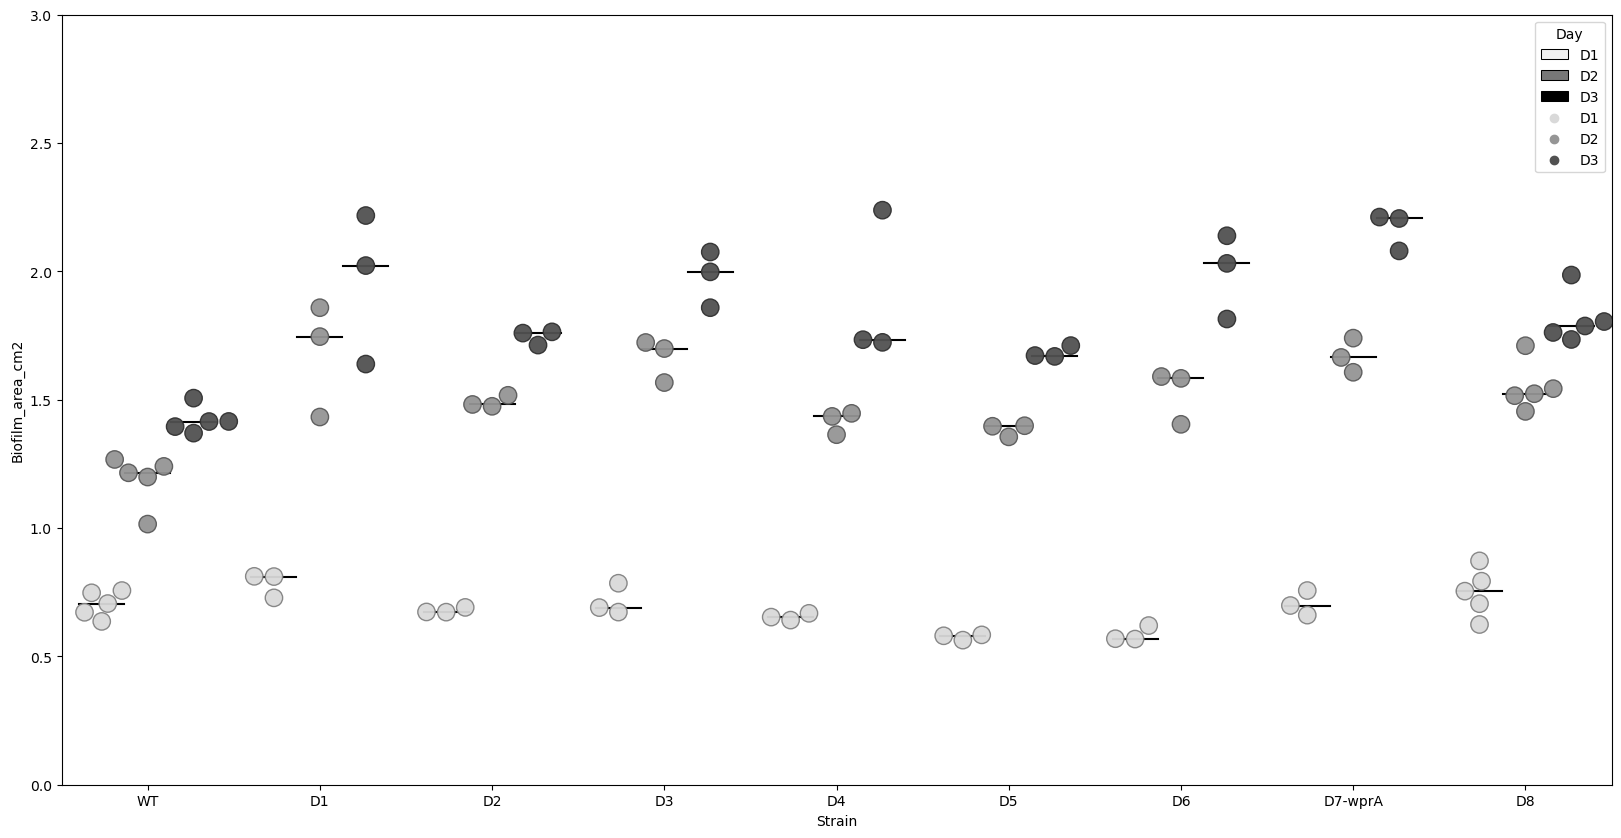

In [31]:
#VISUALISATION OF SUITE DELETION BIOFILM AREA    
fig, axs = plt.subplots(1, 1, figsize=(20,10))
                        
sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= suitedeletionall, order=['WT','D1','D2','D3','D4','D5','D6','D7-wprA','D8'], whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= suitedeletionall, order=['WT','D1','D2','D3','D4','D5','D6','D7-wprA','D8'], dodge=True, s=12.5,alpha=0.95, linewidth=1, palette='Greys')

plt.ylim(0,3)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_Suitedeletion.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_Suitedeletion.svg", dpi = 300)
plt.show()

## Biofilm productivity + Biofilm spores

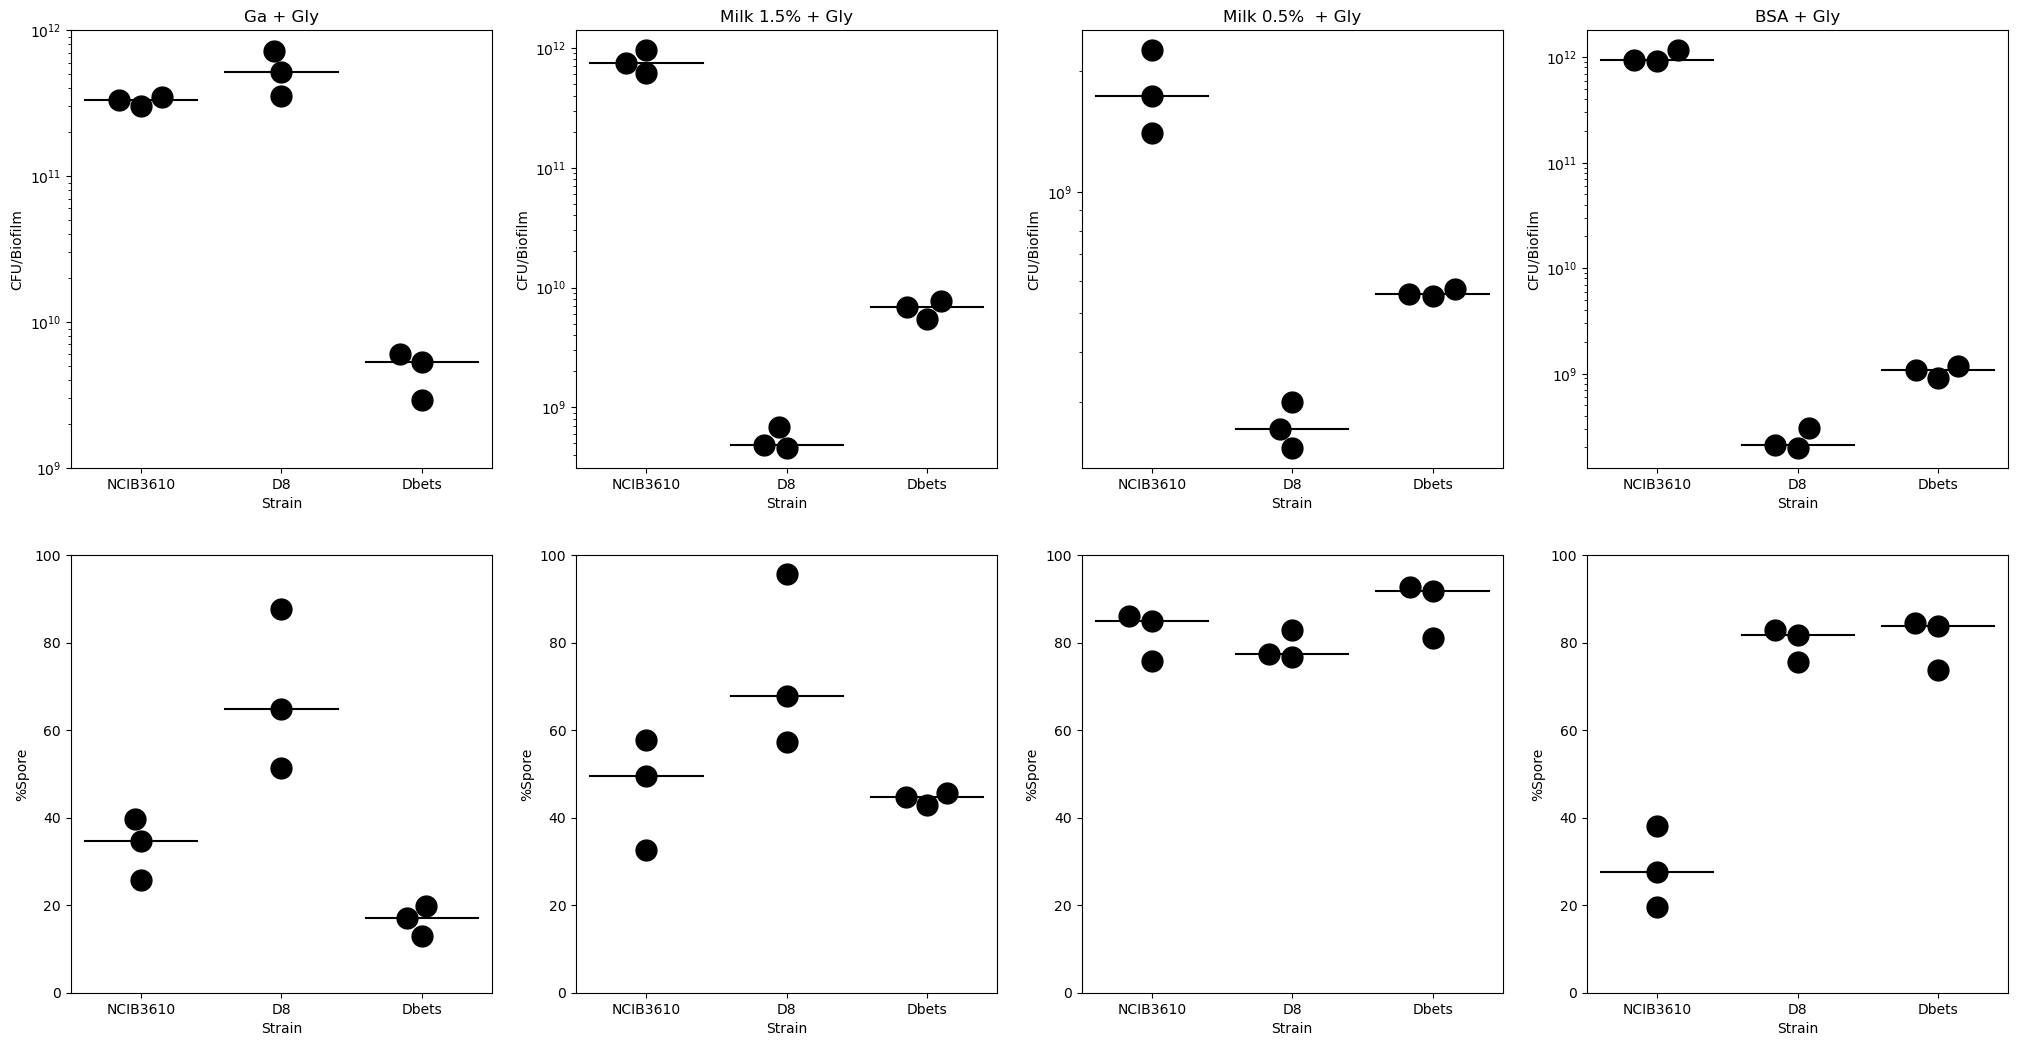

In [32]:
#IMPORT DATA
biofilm_productivity = pd.read_csv(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\20230512_CFU.csv')

#CALCULATING CFU/BIOFILM
CFU_biofilm = []
Spore_biofilm = []

for i, row in biofilm_productivity.iterrows():
    CFU_biofilm.append((row['CFU']*row['Fd'])/row['Dilution'])
    Spore_biofilm.append((row['CFU_HT']*row['Fd'])/row['Dilution'])
    
biofilm_productivity['CFU/Biofilm'] = CFU_biofilm
biofilm_productivity['Spore/Biofilm'] = Spore_biofilm

#CALCULATION % SPORE
proportion_spore = []

for i, row in biofilm_productivity.iterrows():
    proportion_spore.append((row['Spore/Biofilm']/row['CFU/Biofilm'])*100)

biofilm_productivity['%Spore'] = proportion_spore

#DIVIDING DATASET BASED ON MEDIA
biofilm_productivity_msgg = biofilm_productivity[biofilm_productivity['Media'] == 'MSgg']
biofilm_productivity_msmg15 = biofilm_productivity[biofilm_productivity['Media'] == 'MSmg15']
biofilm_productivity_msmg05 = biofilm_productivity[biofilm_productivity['Media'] == 'MSmg05']
biofilm_productivity_msbg = biofilm_productivity[biofilm_productivity['Media'] == 'MSbg']

#VISUALISATION

fig, axs = plt.subplots(2, 4, figsize=(25,12.5))

sns.boxplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,0])
sns.swarmplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msgg, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[0,0])

sns.boxplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msmg15, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,1])
sns.swarmplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msmg15, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[0,1])

sns.boxplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msmg05, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,2])
sns.swarmplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msmg05, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[0,2])

sns.boxplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,3])
sns.swarmplot(x='Strain', y='CFU/Biofilm', data=biofilm_productivity_msbg, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[0,3])

axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[0,2].set_yscale('log')
axs[0,3].set_yscale('log')

axs[0,0].set_ylim(1000000000,1000000000000)

axs[0,0].set_title('Ga + Gly')
axs[0,1].set_title('Milk 1.5% + Gly')
axs[0,2].set_title('Milk 0.5%  + Gly')
axs[0,3].set_title('BSA + Gly')


sns.boxplot(x='Strain', y='%Spore', data=biofilm_productivity_msgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,0])
sns.swarmplot(x='Strain', y='%Spore', data=biofilm_productivity_msgg, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[1,0])

sns.boxplot(x='Strain', y='%Spore', data=biofilm_productivity_msmg15, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,1])
sns.swarmplot(x='Strain', y='%Spore', data=biofilm_productivity_msmg15, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[1,1])

sns.boxplot(x='Strain', y='%Spore', data=biofilm_productivity_msmg05, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,2])
sns.swarmplot(x='Strain', y='%Spore', data=biofilm_productivity_msmg05, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[1,2])

sns.boxplot(x='Strain', y='%Spore', data=biofilm_productivity_msbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,3])
sns.swarmplot(x='Strain', y='%Spore', data=biofilm_productivity_msbg, s=15,dodge=False, edgecolor='black', linewidth=1, color='Black', ax=axs[1,3])

axs[1,0].set_ylim(0,100)
axs[1,1].set_ylim(0,100)
axs[1,2].set_ylim(0,100)
axs[1,3].set_ylim(0,100)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Productivity_spore_MSgg_MSgb_MSgb_MSbb.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Productivity_spore_MSgg_MSgb_MSgb_MSbb.svg", dpi = 300)
plt.show()

In [33]:
biofilm_productivity_msgg.groupby('Strain').mean()

C:\Users\Thibault Rosazza\AppData\Local\Temp\ipykernel_24112\3138451237.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  biofilm_productivity_msgg.groupby('Strain').mean()


Replicate      Dilution   Fd         CFU      CFU_HT   CFU/Biofilm  \
Strain                                                                         
D8              2.0  1.000000e-09  2.0  264.666667  173.666667  5.293333e+11   
Dbets           2.0  1.000000e-07  2.0  237.666667   41.333333  4.753333e+09   
NCIB3610        2.0  1.000000e-09  2.0  164.000000   55.333333  3.280000e+11   

          Spore/Biofilm     %Spore  
Strain                              
D8         3.473333e+11  67.968275  
Dbets      8.266667e+08  16.620793  
NCIB3610   1.106667e+11  33.404509

In [34]:
#STATISTICAL ANALYSIS
#ANOVA test
biofilm_productivity_msgg = biofilm_productivity_msgg.rename({'CFU/Biofilm': 'CFUbiofilm', '%Spore': 'Propspore'}, axis='columns')
biofilm_productivity_msgg_stat1 = biofilm_productivity_msgg[(biofilm_productivity_msgg['Strain'] == 'NCIB3610')|(biofilm_productivity_msgg['Strain'] == 'Dbets')]
biofilm_productivity_msgg_stat2 = biofilm_productivity_msgg[(biofilm_productivity_msgg['Strain'] == 'NCIB3610')|(biofilm_productivity_msgg['Strain'] == 'D8')]
res = stat()
res.anova_stat(df=biofilm_productivity_msgg_stat1, res_var='CFUbiofilm', anova_model='CFUbiofilm ~ C(Strain)')
res.anova_summary

df        sum_sq       mean_sq           F    PR(>F)
C(Strain)  1.0  1.567326e+23  1.567326e+23  561.104239  0.000019
Residual   4.0  1.117315e+21  2.793289e+20         NaN       NaN

In [35]:
res = stat()
res.anova_stat(df=biofilm_productivity_msgg_stat2, res_var='CFUbiofilm', anova_model='CFUbiofilm ~ C(Strain)')
res.anova_summary

df        sum_sq       mean_sq         F    PR(>F)
C(Strain)  1.0  6.080267e+22  6.080267e+22  3.630732  0.129423
Residual   4.0  6.698667e+22  1.674667e+22       NaN       NaN

In [36]:
res = stat()
res.anova_stat(df=biofilm_productivity_msgg_stat1, res_var='Propspore', anova_model='Propspore ~ C(Strain)')
res.anova_summary

df      sum_sq     mean_sq          F    PR(>F)
C(Strain)  1.0  422.539643  422.539643  13.863094  0.020415
Residual   4.0  121.917850   30.479462        NaN       NaN

In [37]:
res = stat()
res.anova_stat(df=biofilm_productivity_msgg_stat2, res_var='Propspore', anova_model='Propspore ~ C(Strain)')
res.anova_summary

df       sum_sq      mean_sq         F    PR(>F)
C(Strain)  1.0  1791.980887  1791.980887  9.304139  0.038018
Residual   4.0   770.401591   192.600398       NaN       NaN

## Reciprocal sharing on MSgg

In [38]:
#IMPORT IMAGES
image_name_list = [f for f in listdir(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_D8_MatrixMutants') if isfile(join(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_D8_MatrixMutants', f))]
image_list = []
for filename in glob.glob(r'C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Images\MSgg_D8_MatrixMutants\*.JPG'):
    im=Image.open(filename)
    image_list.append(im)

#CROP IMAGES
image_crop_list = []
for i in image_list:
    width, height = i.size
    
    left = width/5
    top = height / 8
    right = (width/5)*4
    bottom = (height/8)*7
    
    image_crop = i.crop((left, top, right, bottom))
    image_crop_list.append(image_crop)

#CONVERT IMAGES TO GRAYSCALE
image_gray_list =[]
for i in image_crop_list:
    image_gray = i.convert('L')
    image_gray_list.append(image_gray)
    
#EXTRACT MATRIX FROM IMAGE
image_matrix_list = []
for i in image_gray_list:
    image_matrix = np.asarray(i)
    image_matrix_list.append(image_matrix)

#CREATING A DATASET
image_dataset = pd.DataFrame()
image_dataset['Name'] = image_name_list
image_dataset['Pixel_value'] = image_matrix_list
image_dataset.head()

Name                                        Pixel_value
0       D1_D8_DbslaDeps.JPG  [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...
1      D1_D8_DbslaDtasA.JPG  [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...
2  D1_D8_DepsDbslADtasA.JPG  [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...
3       D1_D8_DepsDtasA.JPG  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...
4     D1_DepsDbslADtasA.JPG  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...

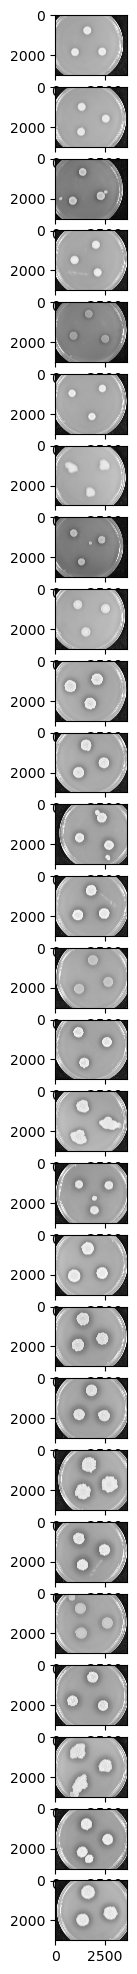

In [39]:
#DATASET VISUALISATION
fig, axs = plt.subplots(ncols=1, nrows=len(image_dataset['Name']), figsize=(15,25))

for i in range(len(image_dataset['Name'])):    
    axs[i].imshow(image_dataset.loc[i,'Pixel_value'], cmap=plt.cm.gray)

plt.show()

In [40]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

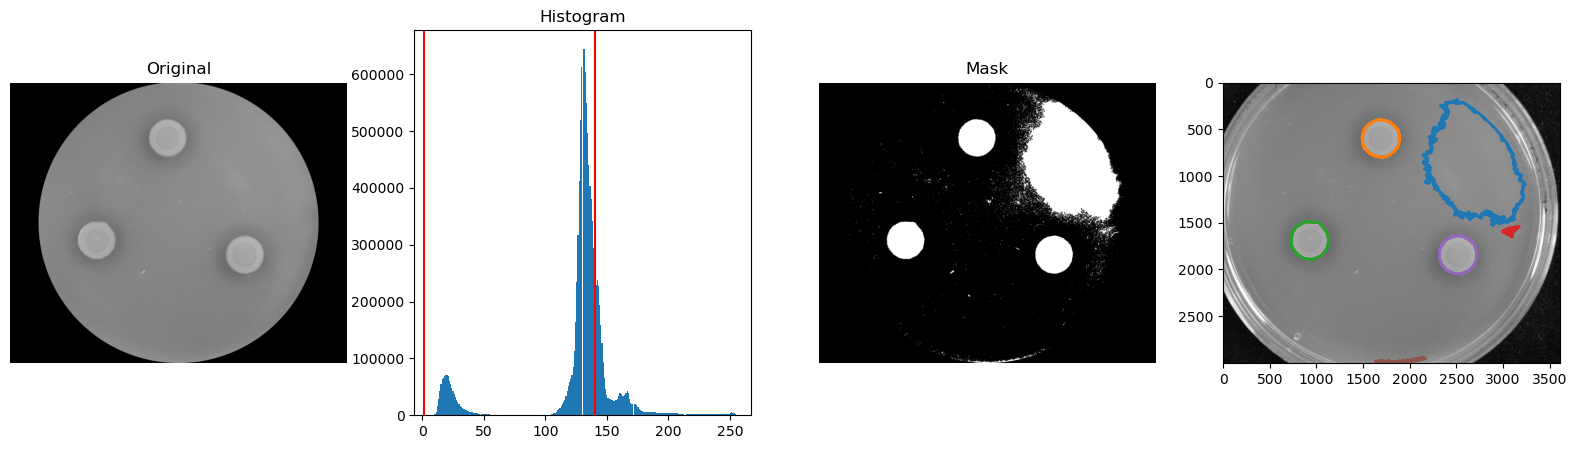

CPU times: total: 3.14 s
Wall time: 3.54 s


In [41]:
%%time
#APPLYING A CIRCULAR MASK TO REMOVE PETRI DISH BORDER
img = image_dataset.loc[4,'Pixel_value']

h, w = img.shape[:2]
mask = create_circular_mask(h, w, radius = h/2)
masked_img = img.copy()
masked_img[~mask] = 0

#FINDING BIOFILM EDGE
Threshold_multiotsu = skm.filters.threshold_multiotsu(masked_img, classes=3)
Img_test_mask = masked_img > (Threshold_multiotsu[1])
Img_test_fill = sc.ndimage.binary_fill_holes(Img_test_mask)

mask = Img_test_fill

Img_test_contours = skm.measure.find_contours(mask, level=False, fully_connected='high', positive_orientation='high')
Img_test_contours_clean = [a for a in Img_test_contours if len(a) > 1500]


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
# Plotting the original image.
ax[0].imshow(masked_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(img.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in Threshold_multiotsu:
    ax[1].axvline(thresh, color='r')
    
ax[2].imshow(Img_test_fill, cmap='gray')
ax[2].set_title('Mask')
ax[2].axis('off')

ax[3].imshow(img, cmap=plt.cm.gray)
for contour in Img_test_contours_clean:  
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    
plt.subplots_adjust()
plt.show()

In [42]:
%%time
dataset = image_dataset

Biofilm_contour =[]

for index, rows in dataset.iterrows():
    Biofilm_image = dataset.loc[index,'Pixel_value']
    
    #Create a circular mask to remove petri dish border
    h, w = Biofilm_image.shape[:2]
    mask = create_circular_mask(h, w, radius=h/2.25)
    masked_img = Biofilm_image.copy()
    masked_img[~mask] = 0
    
    #Dividing histogram signal into three classes
    Threshold_multiotsu = skm.filters.threshold_multiotsu(Biofilm_image, classes=3)
    
    #Removing background signal in the mask
    Img_mask = masked_img > (Threshold_multiotsu[1]) 
    
    #Filling holes in the mask
    Img_fill = sc.ndimage.binary_fill_holes(Img_mask)
        
    #Finding biofilm image
    Img_contours = skm.measure.find_contours(Img_fill, level=False, fully_connected='high', positive_orientation='high')
    
    #Keeping only big contours
    Img_contours_clean = [a for a in Img_contours if len(a) > 1000]
    
    Biofilm_contour.append(Img_contours_clean)

dataset['Biofilm_contour'] = Biofilm_contour

dataset.head()

CPU times: total: 17.4 s
Wall time: 19.1 s


Name  \
0       D1_D8_DbslaDeps.JPG   
1      D1_D8_DbslaDtasA.JPG   
2  D1_D8_DepsDbslADtasA.JPG   
3       D1_D8_DepsDtasA.JPG   
4     D1_DepsDbslADtasA.JPG   

                                         Pixel_value  \
0  [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
1  [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
2  [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
3  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
4  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   

                                     Biofilm_contour  
0  [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...  
1  [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...  
2  [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...  
3  [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...  
4  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...

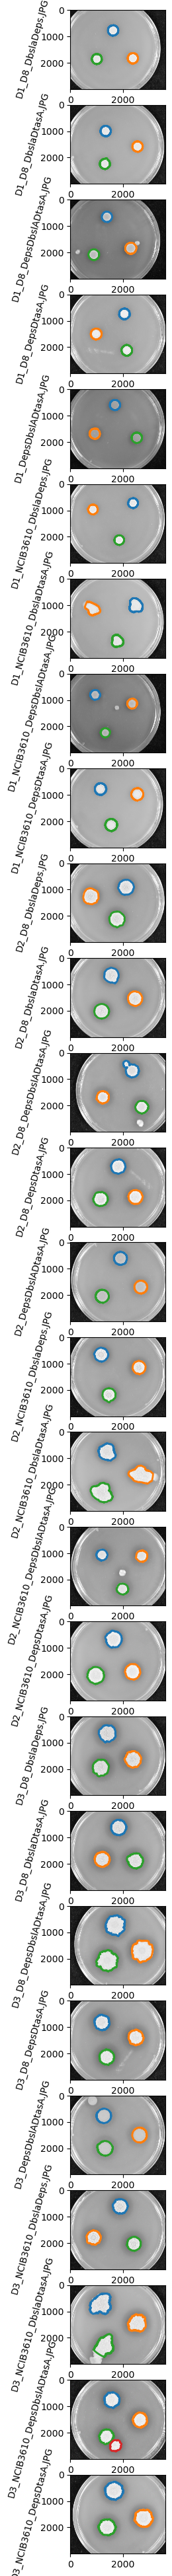

In [43]:
#CONTOUR VISUALISATION

fig, axs = plt.subplots(ncols=1, nrows=len(dataset['Name']), figsize=(5,50))

for i in range(len(dataset['Name'])):    
    axs[i].imshow(dataset.loc[i,'Pixel_value'], cmap=plt.cm.gray)
    axs[i].set_ylabel(dataset.loc[i,'Name'], rotation=75)
        
        
    for contour in dataset.loc[i,'Biofilm_contour']:
        axs[i].plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

In [44]:
%%time
Biofilm1 = []
Biofilm2 = []
Biofilm3 = []

for index, rows in dataset.iterrows():
    Img_name = dataset.loc[index,'Name']
    Biofilms = dataset.loc[index,'Biofilm_contour']
    if Img_name == 'D1_NCIB3610.JPG':
        Biofilm1.append(Biofilms[0])
        Biofilm2.append(Biofilms[4])
        Biofilm3.append(Biofilms[5])
        
    else:
        Biofilm1.append(Biofilms[0])
        Biofilm2.append(Biofilms[1])
        Biofilm3.append(Biofilms[2])
    
dataset['Biofilm_1'] = Biofilm1
dataset['Biofilm_2'] = Biofilm2
dataset['Biofilm_3'] = Biofilm3

dataset.head()

CPU times: total: 0 ns
Wall time: 3.99 ms


Name  \
0       D1_D8_DbslaDeps.JPG   
1      D1_D8_DbslaDtasA.JPG   
2  D1_D8_DepsDbslADtasA.JPG   
3       D1_D8_DepsDtasA.JPG   
4     D1_DepsDbslADtasA.JPG   

                                         Pixel_value  \
0  [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
1  [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
2  [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
3  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
4  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   

                                     Biofilm_contour  \
0  [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
1  [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
2  [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
3  [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
4  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   

                                           Biofilm_1  \
0  [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
1  [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
2  [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
3  [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
4  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   

                                           Biofilm_2  \
0  [[2035.0, 2372.0], [2034.0, 2373.0], [2033.0, ...   
1  [[1784.0, 2562.0], [1783.0, 2563.0], [1782.0, ...   
2  [[2059.0, 2267.0], [2058.0, 2268.0], [2058.0, ...   
3  [[1714.0, 961.0], [1713.0, 962.0], [1713.0, 96...   
4  [[1885.0, 923.0], [1884.0, 924.0], [1883.0, 92...   

                                           Biofilm_3  
0  [[2051.0, 988.0], [2050.0, 989.0], [2049.0, 98...  
1  [[2438.0, 1315.0], [2437.0, 1316.0], [2437.0, ...  
2  [[2296.0, 899.0], [2295.0, 900.0], [2295.0, 90...  
3  [[2329.0, 2152.0], [2328.0, 2153.0], [2327.0, ...  
4  [[2041.0, 2508.0], [2040.0, 2509.0], [2040.0, ...

In [45]:
#SCALE (1cm = 400pixels)
cm = 400
cm2 = cm*cm

#BIOFILM QUANTIFICATION
mask_filled1 = []
mask_filled2 = []
mask_filled3 = []
biofilm_area = []



for index, rows in dataset.iterrows():
    Biofilm_image = dataset.loc[index,'Pixel_value']
    contour1 = dataset.loc[index,'Biofilm_1']
    contour2 = dataset.loc[index,'Biofilm_2']
    contour3 = dataset.loc[index,'Biofilm_3']
    mask1 = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)
    mask2 = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)
    mask3 = np.zeros(shape=(len(Biofilm_image),len(Biofilm_image[0])), dtype=int)

    for i in contour1:
        x_pixel = int(i[0])
        y_pixel = int(i[1])
        mask1[x_pixel,y_pixel] = 1
    for i in contour2:
        x_pixel = int(i[0])
        y_pixel = int(i[1])
        mask2[x_pixel,y_pixel] = 1
    for i in contour3:
        x_pixel = int(i[0])
        y_pixel = int(i[1])
        mask3[x_pixel,y_pixel] = 1
            
    mask_f1 = sc.ndimage.binary_fill_holes(mask1)
    mask_f2 = sc.ndimage.binary_fill_holes(mask2)
    mask_f3 = sc.ndimage.binary_fill_holes(mask3)
    mask_filled1.append(mask_f1.astype(np.uint8))
    mask_filled2.append(mask_f1.astype(np.uint8))
    mask_filled3.append(mask_f1.astype(np.uint8))

    #Measuring area
    props1 = skm.measure.regionprops_table(mask_f1.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    props2 = skm.measure.regionprops_table(mask_f2.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    props3 = skm.measure.regionprops_table(mask_f3.astype(np.uint8),intensity_image=Biofilm_image,properties=('label','area','centroid'))
    biofilm_area.append((props1['area'][0])/cm2)
    biofilm_area.append((props2['area'][0])/cm2)
    biofilm_area.append((props3['area'][0])/cm2) 

dataset = dataset.loc[dataset.index.repeat(3)].reset_index(drop=True)    
dataset['Biofilm_area_cm2'] = biofilm_area
dataset.head(20)

Name  \
0          D1_D8_DbslaDeps.JPG   
1          D1_D8_DbslaDeps.JPG   
2          D1_D8_DbslaDeps.JPG   
3         D1_D8_DbslaDtasA.JPG   
4         D1_D8_DbslaDtasA.JPG   
5         D1_D8_DbslaDtasA.JPG   
6     D1_D8_DepsDbslADtasA.JPG   
7     D1_D8_DepsDbslADtasA.JPG   
8     D1_D8_DepsDbslADtasA.JPG   
9          D1_D8_DepsDtasA.JPG   
10         D1_D8_DepsDtasA.JPG   
11         D1_D8_DepsDtasA.JPG   
12       D1_DepsDbslADtasA.JPG   
13       D1_DepsDbslADtasA.JPG   
14       D1_DepsDbslADtasA.JPG   
15   D1_NCIB3610_DbslaDeps.JPG   
16   D1_NCIB3610_DbslaDeps.JPG   
17   D1_NCIB3610_DbslaDeps.JPG   
18  D1_NCIB3610_DbslaDtasA.JPG   
19  D1_NCIB3610_DbslaDtasA.JPG   

                                          Pixel_value  \
0   [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
1   [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
2   [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
3   [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
4   [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
5   [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
6   [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
7   [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
8   [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
9   [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
10  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
11  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
12  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   
13  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   
14  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   
15  [[33, 34, 34, 34, 37, 43, 47, 45, 43, 40, 37, ...   
16  [[33, 34, 34, 34, 37, 43, 47, 45, 43, 40, 37, ...   
17  [[33, 34, 34, 34, 37, 43, 47, 45, 43, 40, 37, ...   
18  [[40, 38, 36, 33, 29, 26, 27, 33, 40, 50, 56, ...   
19  [[40, 38, 36, 33, 29, 26, 27, 33, 40, 50, 56, ...   

                                      Biofilm_contour  \
0   [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
1   [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
2   [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
3   [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
4   [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
5   [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
6   [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
7   [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
8   [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
9   [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
10  [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
11  [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
12  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   
13  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   
14  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   
15  [[[916.0, 2383.0], [915.0, 2384.0], [914.0, 23...   
16  [[[916.0, 2383.0], [915.0, 2384.0], [914.0, 23...   
17  [[[916.0, 2383.0], [915.0, 2384.0], [914.0, 23...   
18  [[[1268.0, 2405.0], [1267.0, 2406.0], [1266.0,...   
19  [[[1268.0, 2405.0], [1267.0, 2406.0], [1266.0,...   

                                            Biofilm_1  \
0   [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
1   [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
2   [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
3   [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
4   [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
5   [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
6   [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
7   [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
8   [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
9   [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
10  [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
11  [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
12  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   
13  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   
14  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   
15 

In [46]:
#GROUPING DATA BY MEDIA AND MIXING CONDITIONS

day = []
for index, rows in dataset.iterrows():
    Img_name = dataset.loc[index,'Name']
    if 'D1_' in Img_name:
        day.append('D1')
    elif 'D2_' in Img_name:
        day.append('D2')
    elif 'D3_' in Img_name:
        day.append('D3')    
dataset['Day'] = day

strain = []
for index, rows in dataset.iterrows():
    Img_name = dataset.loc[index,'Name']
    if '_NCIB3610_DbslaDeps' in Img_name:
        strain.append('NCIB3610_DbslaDeps')
    elif '_NCIB3610_DbslaDtasA'in Img_name:
        strain.append('NCIB3610_DbslaDtasA')
    elif '_NCIB3610_DepsDtasA'in Img_name:
        strain.append('NCIB3610_DepsDtasA')
    elif '_NCIB3610_DepsDbslADtasA'in Img_name:
        strain.append('NCIB3610_DbslaDepsDtasA')
    elif '_D8_DbslaDeps' in Img_name:
        strain.append('D8_DbslaDeps')
    elif '_D8_DbslaDtasA'in Img_name:
        strain.append('D8_DbslaDtasA')
    elif '_D8_DepsDtasA'in Img_name:
        strain.append('D8_DepsDtasA')
    elif '_D8_DepsDbslADtasA'in Img_name:
        strain.append('D8_DbslaDepsDtasA')
    elif'_DepsDbslADtasA.JPG' in Img_name:
        strain.append('DbslaDepsDtasA')
        
dataset['Strain'] = strain
D8_MM_dataset = dataset
D8_MM_dataset.head(20)

Name  \
0          D1_D8_DbslaDeps.JPG   
1          D1_D8_DbslaDeps.JPG   
2          D1_D8_DbslaDeps.JPG   
3         D1_D8_DbslaDtasA.JPG   
4         D1_D8_DbslaDtasA.JPG   
5         D1_D8_DbslaDtasA.JPG   
6     D1_D8_DepsDbslADtasA.JPG   
7     D1_D8_DepsDbslADtasA.JPG   
8     D1_D8_DepsDbslADtasA.JPG   
9          D1_D8_DepsDtasA.JPG   
10         D1_D8_DepsDtasA.JPG   
11         D1_D8_DepsDtasA.JPG   
12       D1_DepsDbslADtasA.JPG   
13       D1_DepsDbslADtasA.JPG   
14       D1_DepsDbslADtasA.JPG   
15   D1_NCIB3610_DbslaDeps.JPG   
16   D1_NCIB3610_DbslaDeps.JPG   
17   D1_NCIB3610_DbslaDeps.JPG   
18  D1_NCIB3610_DbslaDtasA.JPG   
19  D1_NCIB3610_DbslaDtasA.JPG   

                                          Pixel_value  \
0   [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
1   [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
2   [[34, 35, 35, 35, 36, 36, 35, 36, 37, 37, 37, ...   
3   [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
4   [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
5   [[55, 53, 51, 47, 43, 41, 41, 43, 46, 46, 47, ...   
6   [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
7   [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
8   [[18, 17, 17, 17, 17, 19, 20, 19, 19, 18, 18, ...   
9   [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
10  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
11  [[35, 39, 42, 43, 45, 44, 41, 40, 40, 38, 37, ...   
12  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   
13  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   
14  [[26, 26, 23, 22, 23, 24, 23, 22, 24, 26, 27, ...   
15  [[33, 34, 34, 34, 37, 43, 47, 45, 43, 40, 37, ...   
16  [[33, 34, 34, 34, 37, 43, 47, 45, 43, 40, 37, ...   
17  [[33, 34, 34, 34, 37, 43, 47, 45, 43, 40, 37, ...   
18  [[40, 38, 36, 33, 29, 26, 27, 33, 40, 50, 56, ...   
19  [[40, 38, 36, 33, 29, 26, 27, 33, 40, 50, 56, ...   

                                      Biofilm_contour  \
0   [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
1   [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
2   [[[975.0, 1592.0], [974.0, 1593.0], [973.0, 15...   
3   [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
4   [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
5   [[[1196.0, 1341.0], [1195.0, 1342.0], [1194.0,...   
6   [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
7   [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
8   [[[846.0, 1416.0], [845.0, 1417.0], [844.0, 14...   
9   [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
10  [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
11  [[[946.0, 2019.0], [945.0, 2020.0], [944.0, 20...   
12  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   
13  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   
14  [[[792.0, 1701.0], [791.0, 1702.0], [790.0, 17...   
15  [[[916.0, 2383.0], [915.0, 2384.0], [914.0, 23...   
16  [[[916.0, 2383.0], [915.0, 2384.0], [914.0, 23...   
17  [[[916.0, 2383.0], [915.0, 2384.0], [914.0, 23...   
18  [[[1268.0, 2405.0], [1267.0, 2406.0], [1266.0,...   
19  [[[1268.0, 2405.0], [1267.0, 2406.0], [1266.0,...   

                                            Biofilm_1  \
0   [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
1   [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
2   [[975.0, 1592.0], [974.0, 1593.0], [973.0, 159...   
3   [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
4   [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
5   [[1196.0, 1341.0], [1195.0, 1342.0], [1194.0, ...   
6   [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
7   [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
8   [[846.0, 1416.0], [845.0, 1417.0], [844.0, 141...   
9   [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
10  [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
11  [[946.0, 2019.0], [945.0, 2020.0], [944.0, 202...   
12  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   
13  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   
14  [[792.0, 1701.0], [791.0, 1702.0], [790.0, 170...   
15 

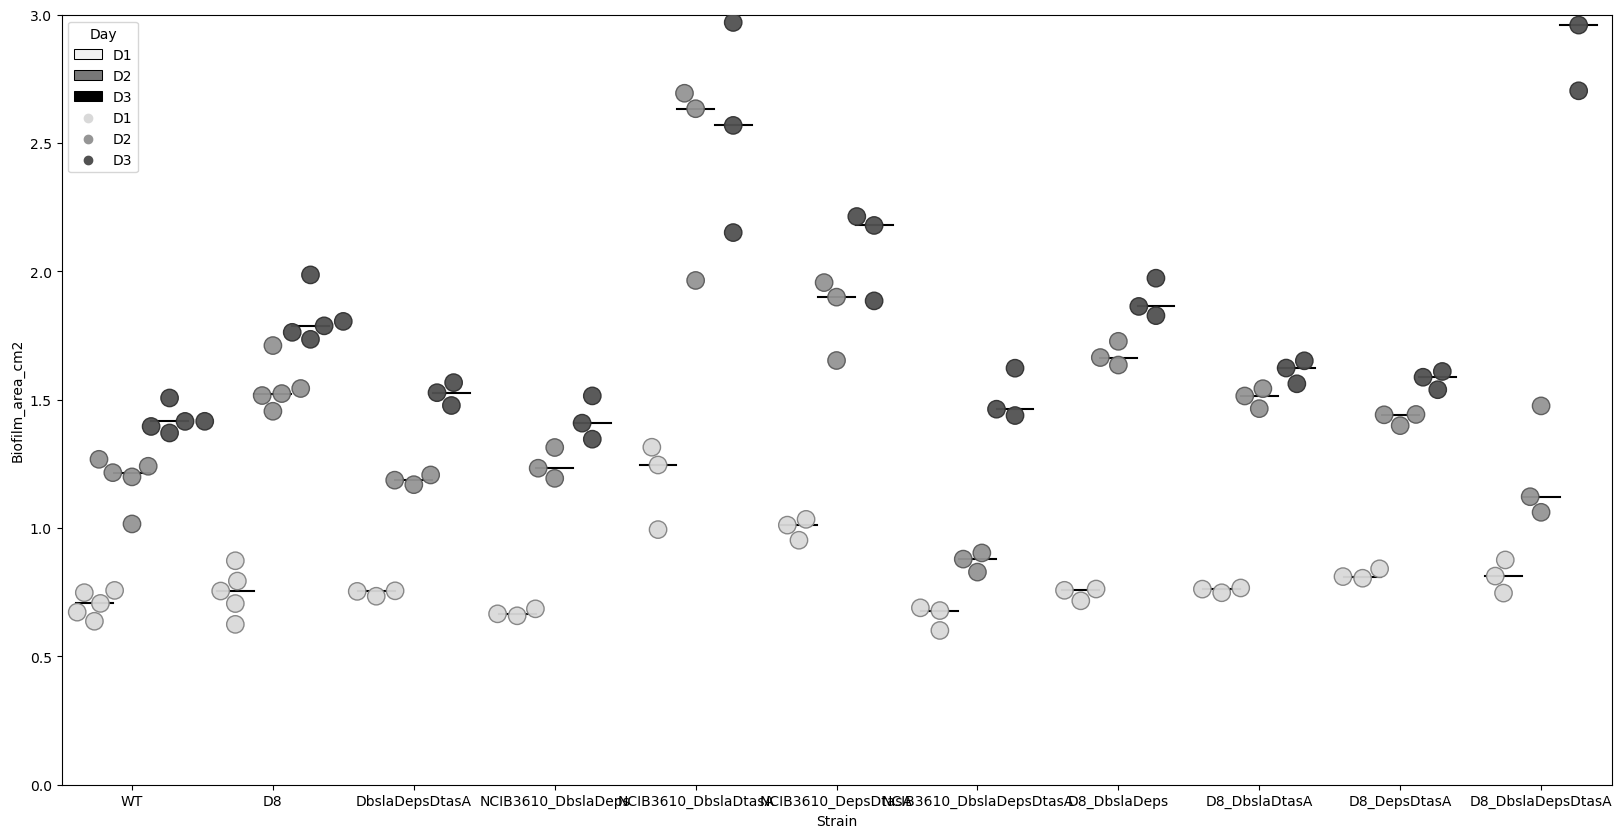

In [47]:
#VISUALISATION OF MONOPRODUCER BIOFILM AREA  
All_D8_MM_dataset = pd.concat([D8_MM_dataset,WTD8_MSgg_D1D3], ignore_index=True)

fig, axs = plt.subplots(1, 1, figsize=(20,10))
                        
sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= All_D8_MM_dataset, order=['WT','D8','DbslaDepsDtasA','NCIB3610_DbslaDeps','NCIB3610_DbslaDtasA','NCIB3610_DepsDtasA','NCIB3610_DbslaDepsDtasA','D8_DbslaDeps','D8_DbslaDtasA','D8_DepsDtasA','D8_DbslaDepsDtasA'], whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= All_D8_MM_dataset, order=['WT','D8','DbslaDepsDtasA','NCIB3610_DbslaDeps','NCIB3610_DbslaDtasA','NCIB3610_DepsDtasA','NCIB3610_DbslaDepsDtasA','D8_DbslaDeps','D8_DbslaDtasA','D8_DepsDtasA','D8_DbslaDepsDtasA'], dodge=True, s=12.5,alpha=0.95, linewidth=1, palette='Greys')

plt.ylim(0,3)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_ReciprocalSharing_MSgg.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_ReciprocalSharing_MSgg.svg", dpi = 300)
plt.show()

In [48]:
All_D8_MM_dataset_d3 = All_D8_MM_dataset[All_D8_MM_dataset['Day'] =='D3']
All_D8_MM_dataset_d3.groupby('Strain').mean()

C:\Users\Thibault Rosazza\AppData\Local\Temp\ipykernel_24112\2960570333.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  All_D8_MM_dataset_d3.groupby('Strain').mean()


Biofilm_area_cm2  Ra_index
Strain                                             
D8                               1.814876    1840.6
D8_DbslaDeps                     1.887621       NaN
D8_DbslaDepsDtasA                2.941296       NaN
D8_DbslaDtasA                    1.611798       NaN
D8_DepsDtasA                     1.578354       NaN
DbslaDepsDtasA                   1.523315       NaN
NCIB3610_DbslaDeps               1.422746       NaN
NCIB3610_DbslaDepsDtasA          1.507560       NaN
NCIB3610_DbslaDtasA              2.562738       NaN
NCIB3610_DepsDtasA               2.092085       NaN
WT                               1.420354    1745.0

In [49]:
#STATISTICAL ANALYSIS
#ANOVA test
res = stat()
res.anova_stat(df=All_D8_MM_dataset_d3, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Strain)')
res.anova_summary

df    sum_sq   mean_sq          F        PR(>F)
C(Strain)  10.0  7.795701  0.779570  33.069436  2.949177e-12
Residual   26.0  0.612917  0.023574        NaN           NaN

In [50]:
All_D8_MM_dataset_d3_stat_1 = All_D8_MM_dataset_d3[(All_D8_MM_dataset_d3['Strain'] == 'D8')|(All_D8_MM_dataset_d3['Strain'] == 'D8_DbslaDepsDtasA')]

res = stat()
res.anova_stat(df=All_D8_MM_dataset_d3_stat_1, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Strain)')
res.anova_summary

df    sum_sq   mean_sq          F    PR(>F)
C(Strain)  1.0  2.379040  2.379040  98.451369  0.000061
Residual   6.0  0.144988  0.024165        NaN       NaN

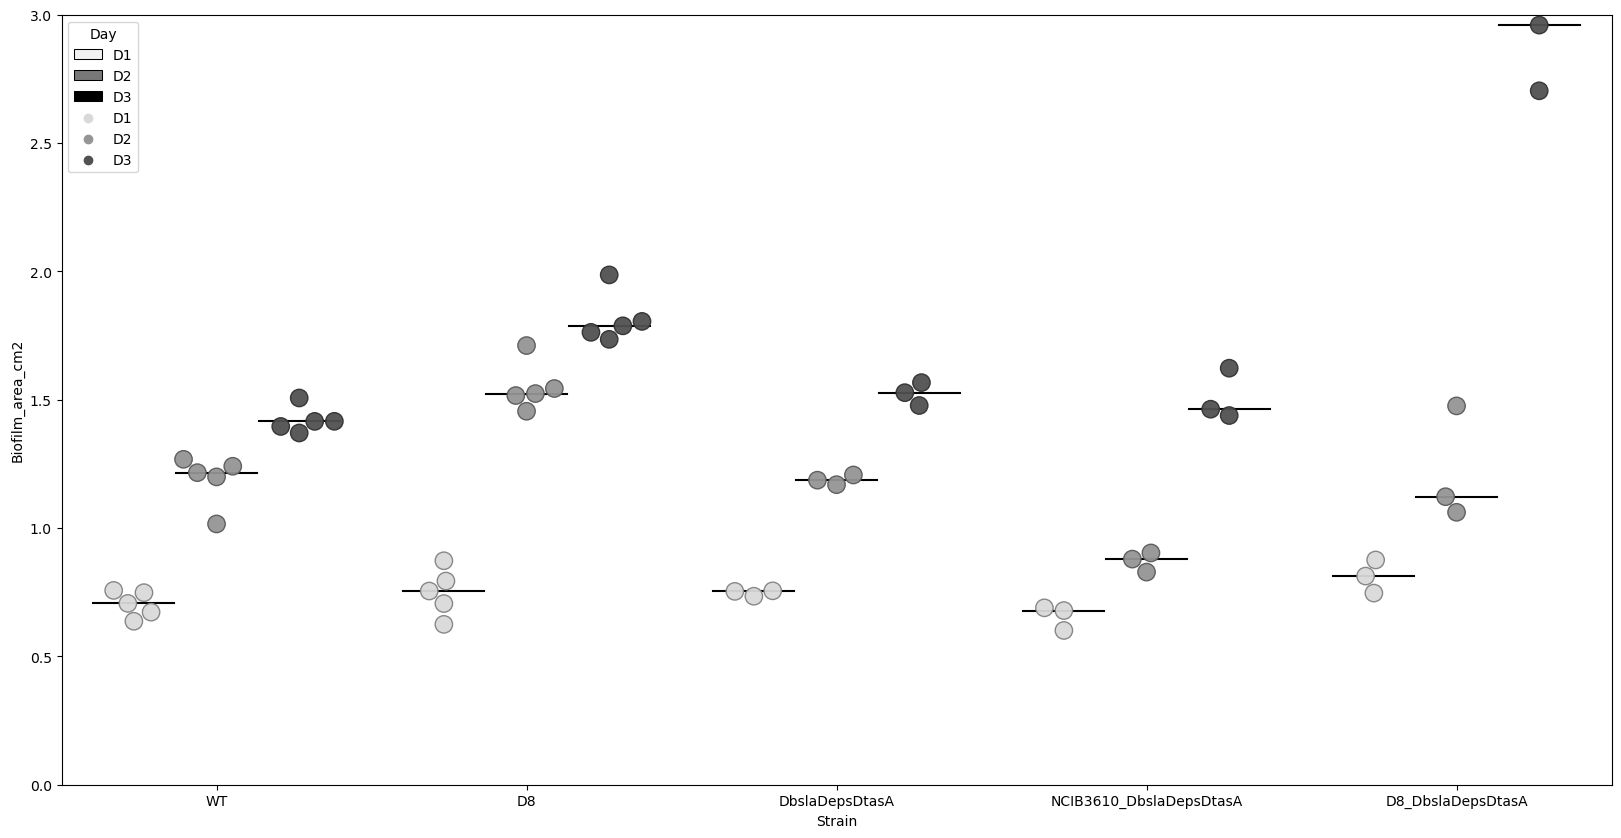

In [51]:
#VISUALISATION OF MONOPRODUCER BIOFILM AREA  
small_D8_MM_dataset = All_D8_MM_dataset[(All_D8_MM_dataset['Strain'] == 'WT')|(All_D8_MM_dataset['Strain'] == 'D8')|(All_D8_MM_dataset['Strain'] == 'DbslaDepsDtasA')|(All_D8_MM_dataset['Strain'] == 'NCIB3610_DbslaDepsDtasA')|(All_D8_MM_dataset['Strain'] == 'D8_DbslaDepsDtasA')]

fig, axs = plt.subplots(1, 1, figsize=(20,10))
                        
sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= small_D8_MM_dataset, order=['WT','D8','DbslaDepsDtasA','NCIB3610_DbslaDepsDtasA','D8_DbslaDepsDtasA'], whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', data= small_D8_MM_dataset, order=['WT','D8','DbslaDepsDtasA','NCIB3610_DbslaDepsDtasA','D8_DbslaDepsDtasA'], dodge=True, s=12.5,alpha=0.95, linewidth=1, palette='Greys')

plt.ylim(0,3)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_ReciprocalSharing_MSgg_small.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\FootprintArea_ReciprocalSharing_MSgg_small.svg", dpi = 300)
plt.show()

In [52]:
small_D8_MM_dataset_d3 = small_D8_MM_dataset[small_D8_MM_dataset['Day'] == 'D3']
small_D8_MM_dataset_d3.groupby('Strain').mean()

C:\Users\Thibault Rosazza\AppData\Local\Temp\ipykernel_24112\4230938424.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  small_D8_MM_dataset_d3.groupby('Strain').mean()


Biofilm_area_cm2  Ra_index
Strain                                             
D8                               1.814876    1840.6
D8_DbslaDepsDtasA                2.941296       NaN
DbslaDepsDtasA                   1.523315       NaN
NCIB3610_DbslaDepsDtasA          1.507560       NaN
WT                               1.420354    1745.0

In [53]:
#STATISTICAL ANALYSIS
#ANOVA test
res = stat()
res.anova_stat(df=small_D8_MM_dataset, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Strain)')
res.anova_summary

df     sum_sq   mean_sq         F    PR(>F)
C(Strain)   4.0   2.632785  0.658196  2.346592  0.066536
Residual   52.0  14.585496  0.280490       NaN       NaN

## Biofilm area on MSgg, MSgb, MSbg and MSbb

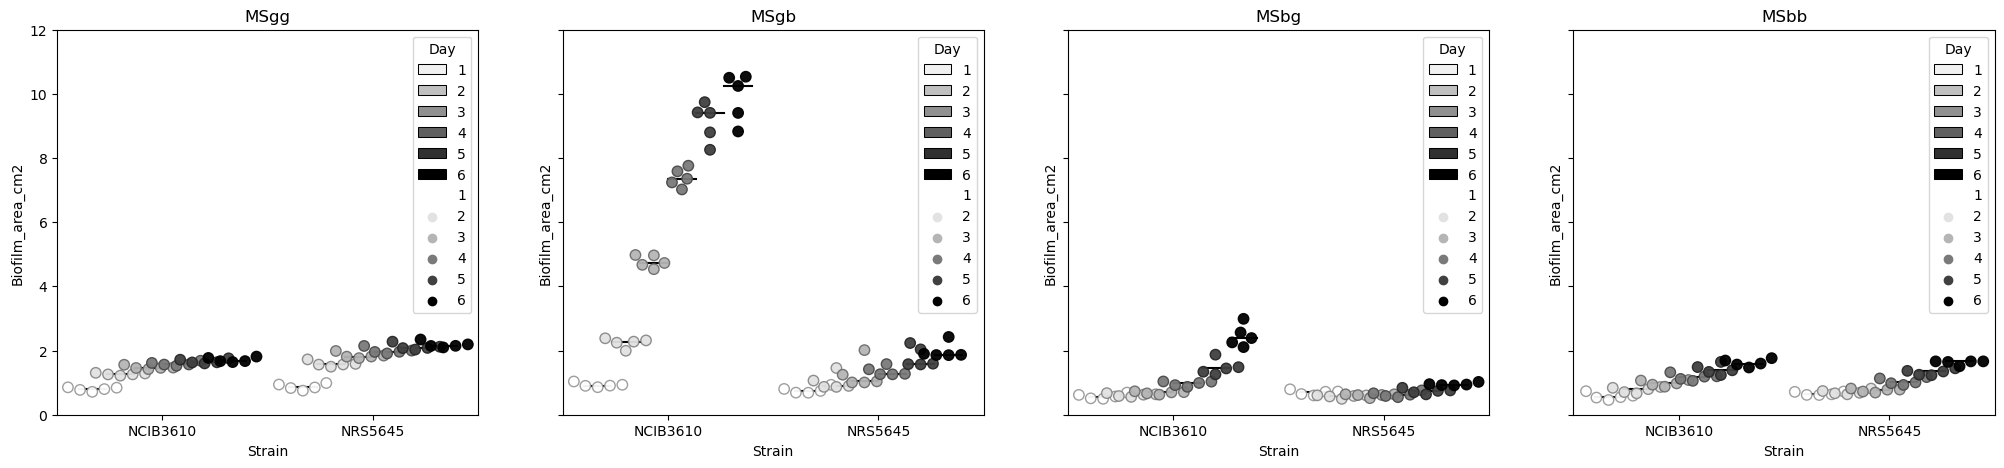

In [54]:
#IMPORT DATA
Biofilm_area = pd.read_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Biofilm_area_MSgg_MSgb_MSbg_MSbb_2.csv")

#SCALE (1cm = 400pixels)
cm = 400
cm2 = cm*cm

area_cm2 = []
for index, rows in Biofilm_area.iterrows():
    area_cm2.append(Biofilm_area.loc[index,'colonyArea_pix']/cm2)

Biofilm_area['Biofilm_area_cm2'] = area_cm2
    
    
#DIVIDING THE DATASET
area_msgg = Biofilm_area[Biofilm_area['Media'] == 'MSgg']
area_msgb = Biofilm_area[Biofilm_area['Media'] == 'MSgb']
area_msbg = Biofilm_area[Biofilm_area['Media'] == 'MSbg']
area_msbb = Biofilm_area[Biofilm_area['Media'] == 'MSbb']

#VISUALISATION
fig, axs = plt.subplots(1, 4, figsize=(25, 5), sharey=True)

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msgg, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[0])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msgb, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msgb, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[1])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[2])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msbg, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[2])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msbb, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[3])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msbb, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[3])

axs[0].set_ylim(0,12)
axs[1].set_ylim(0,12)
axs[2].set_ylim(0,12)
axs[3].set_ylim(0,12)

axs[0].set_title('MSgg')
axs[1].set_title('MSgb')
axs[2].set_title('MSbg')
axs[3].set_title('MSbb')

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Area_MSgg_MSgb_MSgb_MSbb.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Area_MSgg_MSgb_MSgb_MSbb.svg", dpi = 300)
plt.show()

## Biofilm halo quantification on MSmg

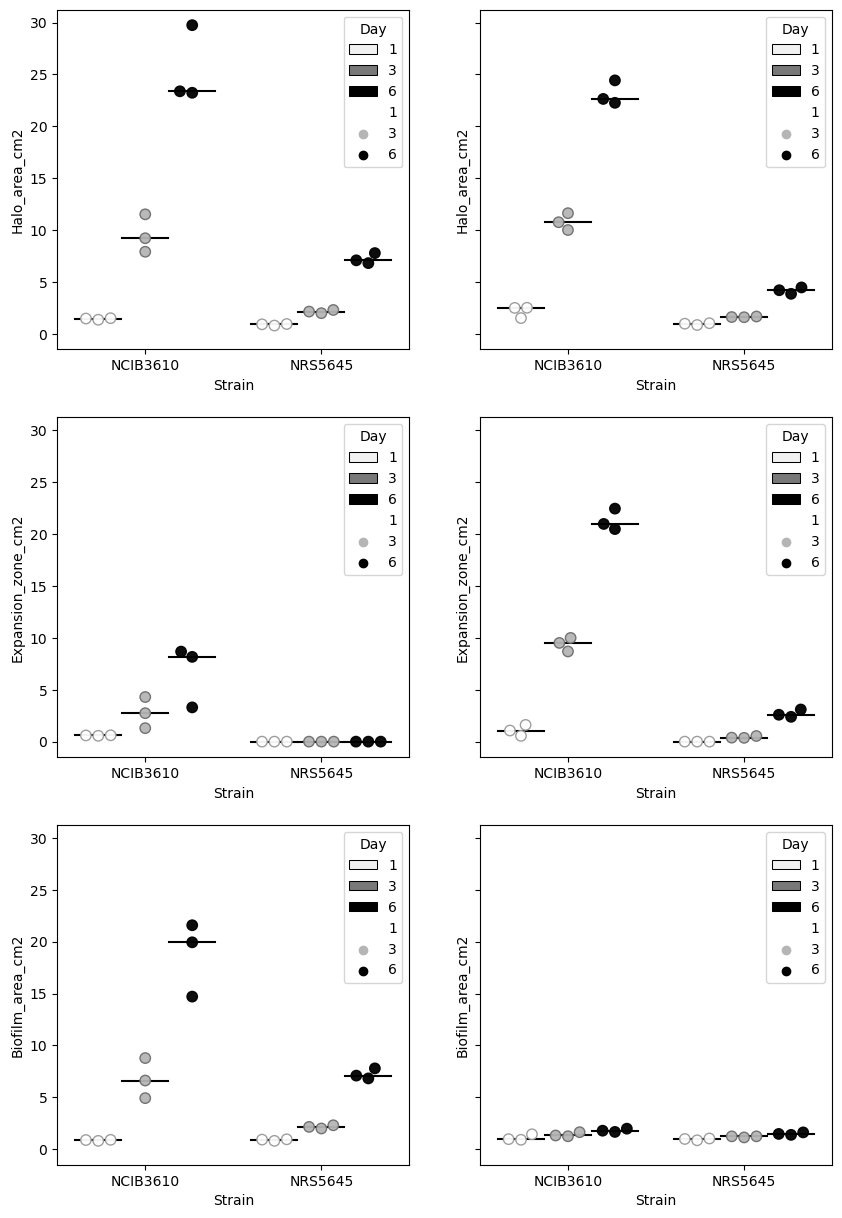

In [55]:
#IMPORT DATA
Biofilm_halo = pd.read_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\MSmg_halo_biofilm_sizes_2.csv")

#SCALE (1cm = 400pixels)
cm = 400
cm2 = cm*cm

biofilm_area_cm2 = []
halo_area_cm2 = []
expanding_halo = []

for index, rows in Biofilm_halo.iterrows():
    biofilm_area = Biofilm_halo.loc[index,'Biofilm_area']/cm2
    halo_area = Biofilm_halo.loc[index,'Halo_area']/cm2
    expansion_zone = halo_area - biofilm_area
    biofilm_area_cm2.append(biofilm_area)
    halo_area_cm2.append(halo_area)
    expanding_halo.append(expansion_zone)
    
Biofilm_halo['Biofilm_area_cm2'] = biofilm_area_cm2
Biofilm_halo['Halo_area_cm2'] = halo_area_cm2   
Biofilm_halo['Expansion_zone_cm2'] = expanding_halo    

#DIVIDING DATASET
Biofilm_halo_msmg05 = Biofilm_halo[Biofilm_halo['Medium'] == 'MSmg05']
Biofilm_halo_msmg15 = Biofilm_halo[Biofilm_halo['Medium'] == 'MSmg15']

    
#VISUALISATION
fig, axs = plt.subplots(3, 2, figsize=(10, 15), sharey=True)

sns.boxplot(x='Strain', y='Halo_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,0])
sns.swarmplot(x='Strain', y='Halo_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[0,0])

sns.boxplot(x='Strain', y='Halo_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg05, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,1])
sns.swarmplot(x='Strain', y='Halo_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg05, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[0,1])

sns.boxplot(x='Strain', y='Expansion_zone_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,0])
sns.swarmplot(x='Strain', y='Expansion_zone_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[1,0])

sns.boxplot(x='Strain', y='Expansion_zone_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg05, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,1])
sns.swarmplot(x='Strain', y='Expansion_zone_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg05, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[1,1])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[2,0])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[2,0])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg05, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[2,1])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg05, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[2,1])

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Halo_area_MSmg.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Halo_area_MSmg.svg", dpi = 300)
plt.show()

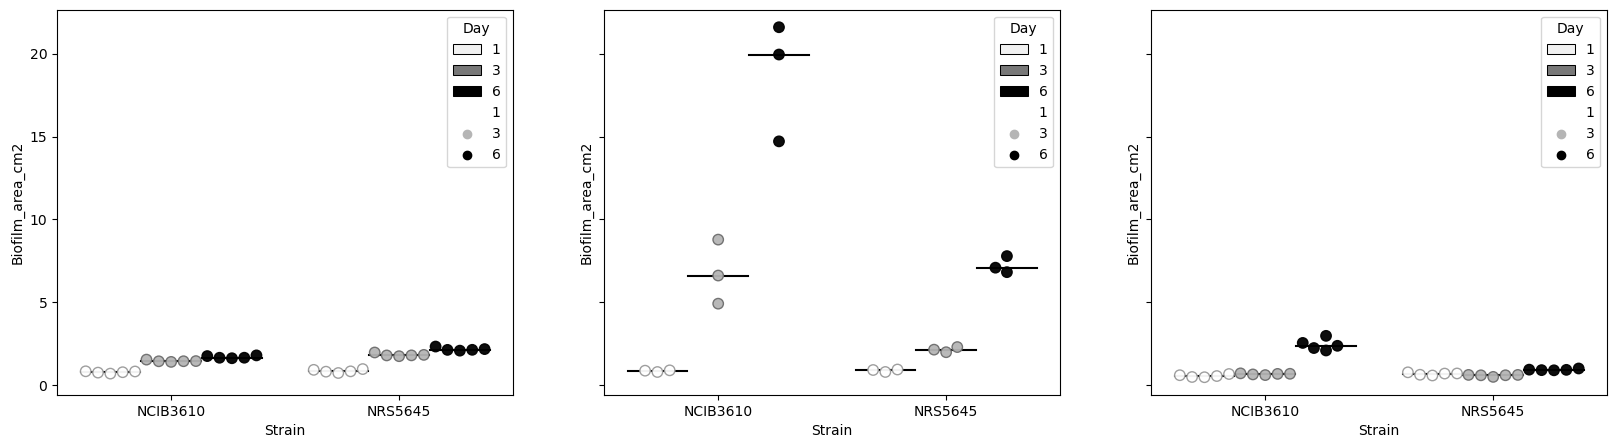

In [56]:
area_msgg_2 = area_msgg[(area_msgg['Day'] == 1)|(area_msgg['Day'] == 3)|(area_msgg['Day'] == 6)]
area_msbg_2 = area_msbg[(area_msbg['Day'] == 1)|(area_msbg['Day'] == 3)|(area_msbg['Day'] == 6)]

#VISUALISATION
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msgg_2, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msgg_2, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[0])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=Biofilm_halo_msmg15, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[1])

sns.boxplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msbg_2, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[2])
sns.swarmplot(x='Strain', y='Biofilm_area_cm2', hue='Day', order=['NCIB3610','NRS5645'], data=area_msbg_2, dodge=True, s=7.5,alpha=0.95, linewidth=1, palette='Greys', ax=axs[2])

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure6.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure6.svg", dpi = 300)
plt.show()

## Biofilm hydrophobicity on MSgg, MSgb, MSbg and MSbb

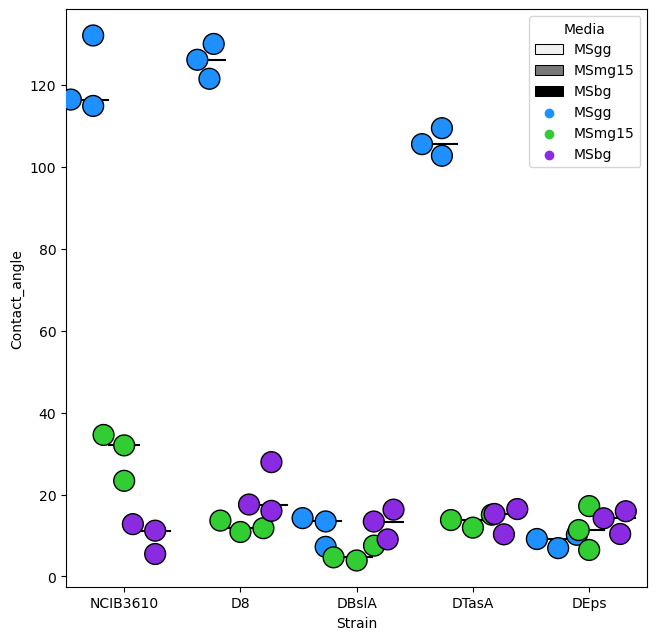

In [57]:
#IMPORT DbATA
Biofilm_hydrophobicity = pd.read_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\MSgg_MSmg_MSbg_hydrophobicity.csv")
Biofilm_hydrophobicity = Biofilm_hydrophobicity[Biofilm_hydrophobicity['Strain'] != 'DTapA']
Biofilm_hydrophobicity = Biofilm_hydrophobicity[Biofilm_hydrophobicity['Media'] != 'MSmg05']

#DIVIDING DATASET
hydro_msgg = Biofilm_hydrophobicity[Biofilm_hydrophobicity['Media'] == 'MSgg']
hydro_msmg15 = Biofilm_hydrophobicity[Biofilm_hydrophobicity['Media'] == 'MSmg15']
hydro_msmg05 = Biofilm_hydrophobicity[Biofilm_hydrophobicity['Media'] == 'MSmg05']
hydro_msbg = Biofilm_hydrophobicity[Biofilm_hydrophobicity['Media'] == 'MSbg']

#VISUALISATION
fig, axs = plt.subplots(1, 1, figsize=(7.5,7.5), sharey=True)

sns.boxplot(x='Strain', y='Contact_angle', hue='Media', data=Biofilm_hydrophobicity, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black')
sns.swarmplot(x='Strain', y='Contact_angle', hue='Media', data=Biofilm_hydrophobicity, s=15,dodge=True, edgecolor='black', linewidth=1, palette=['dodgerblue','limegreen','blueviolet'])


plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Hydrophobicity_MSgg_MSgb_MSgb_MSbb.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Hydrophobicity_MSgg_MSgb_MSgb_MSbb.svg", dpi = 300)
plt.show()

## Fluorescence quantification

In [58]:
fluo_quantif = pd.read_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Reciprocalsharing_quantif.csv")
fluo_quantif.head()

Day Medium       Mix  Replicate  \
0    3   MSgg  WT_DbslA          1   
1    3   MSgg  WT_DbslA          2   
2    3   MSgg  WT_DbslA          3   
3    3   MSgg   WT_Deps          1   
4    3   MSgg   WT_Deps          2   

                                               Label  colonyArea_micron2  \
0  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...           193002488   
1  20230328_MatrixMutantBiofilms.lif - D3_MSgg_WT...           229351971   
2  20230414_WT-D8_MatrixMutants_D3.lif - D3_MSgg_...           311565194   
3  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...           181413810   
4  20230328_MatrixMutantBiofilms.lif - D3_MSgg_WT...           216708250   

   greenMean  greenMax  greenStd  greenTotal  greenForegroundTotal  pctGreen  \
0   1431.879      3330   563.317   494469184             493748696    98.905   
1   1298.768      2690   365.733   538537895             538518508    99.981   
2   1297.866      2909   456.917   731073913             730017750    99.102   
3   1033.218      2506   453.304   335376314             333283897    96.643   
4    858.500      2149   350.819   336355140             332570200    94.612   

    redMean  redMax   redStd   redTotal  redForegroundTotal  pctRed    PCC  \
0   903.515    2332  344.770  312010087           311803364  99.374  0.203   
1  1251.391    3431  481.501  518893008           518892017  99.999  0.512   
2  1305.679    3925  593.091  735474653           735471502  99.997  0.626   
3  1243.760    2543  410.039  403717078           402797772  97.403  0.310   
4  2416.082    4095  991.231  946606612           945738960  98.245  0.410   

   PCC_obj  
0    0.160  
1    0.512  
2    0.622  
3    0.248  
4    0.350

In [59]:
# CALCULATING RELATIVE DENSITY OF STRAINS
Density_green = []
Density_red = []

for index, row in fluo_quantif.iterrows():
    Green_pop = row['pctGreen']
    Red_pop = row['pctRed']
    pop_tot = Green_pop + Red_pop
    Density_green.append(Green_pop/pop_tot)
    Density_red.append(Red_pop/pop_tot)

fluo_quantif['Density_green'] = Density_green
fluo_quantif['Density_red'] = Density_red

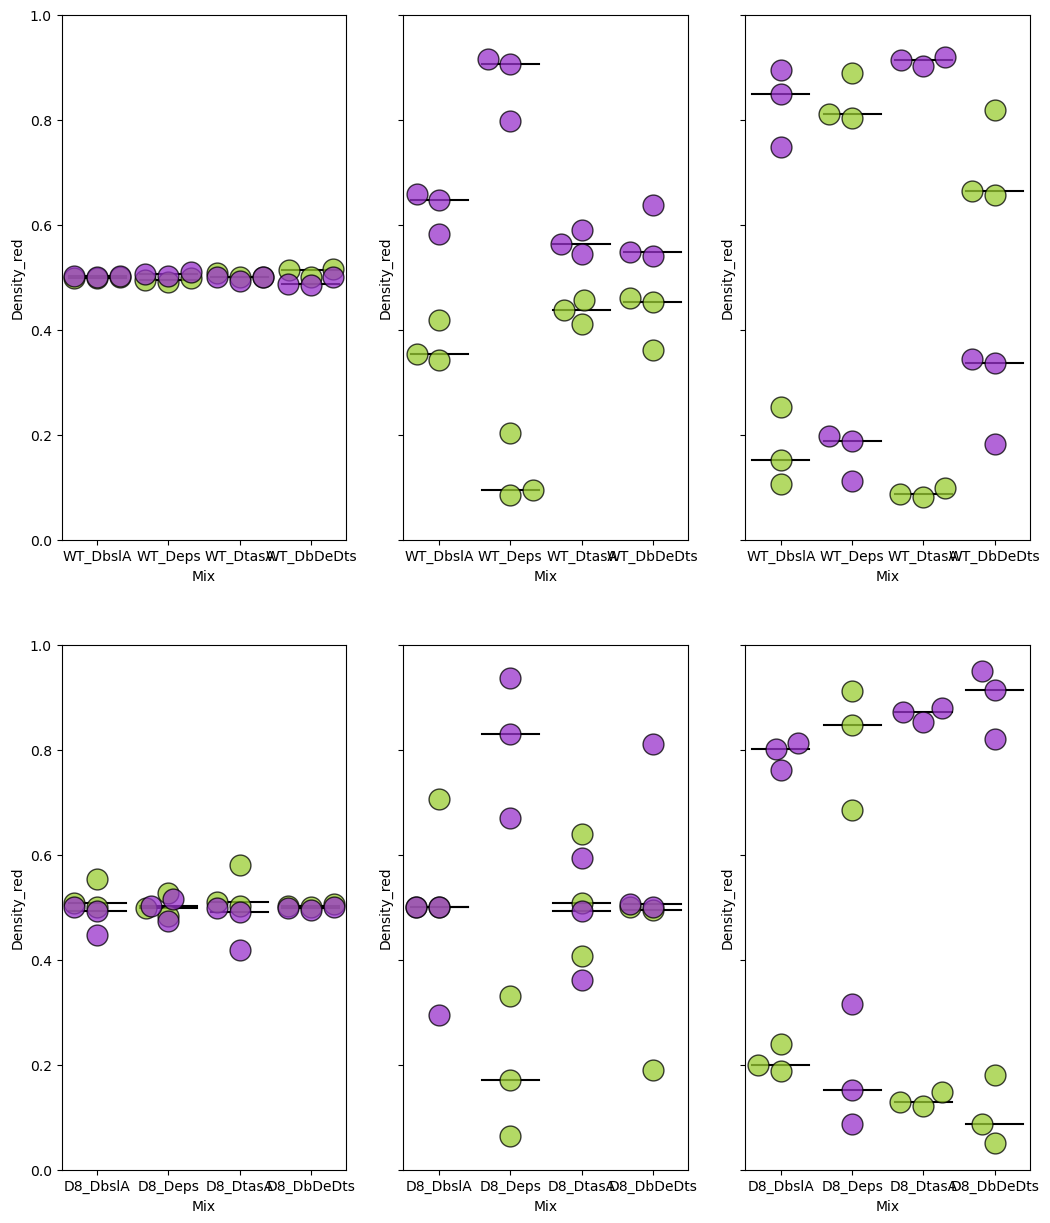

In [60]:
#DIVIDING DATASET BASED ON MEDIUM AND STRAIN
fluo_quantif_WT = fluo_quantif[(fluo_quantif['Mix'] == 'WT_DbslA')|(fluo_quantif['Mix'] == 'WT_Deps')|(fluo_quantif['Mix'] == 'WT_DtasA')|(fluo_quantif['Mix'] == 'WT_DbDeDts')]
fluo_quantif_D8 = fluo_quantif[(fluo_quantif['Mix'] == 'D8_DbslA')|(fluo_quantif['Mix'] == 'D8_Deps')|(fluo_quantif['Mix'] == 'D8_DtasA')|(fluo_quantif['Mix'] == 'D8_DbDeDts')]

fluo_quantif_WT_MSgg = fluo_quantif_WT[fluo_quantif_WT['Medium'] == 'MSgg']
fluo_quantif_WT_MSmg = fluo_quantif_WT[fluo_quantif_WT['Medium'] == 'MSmg']
fluo_quantif_WT_MSbg = fluo_quantif_WT[fluo_quantif_WT['Medium'] == 'MSbg']

fluo_quantif_D8_MSgg = fluo_quantif_D8[fluo_quantif_D8['Medium'] == 'MSgg']
fluo_quantif_D8_MSmg = fluo_quantif_D8[fluo_quantif_D8['Medium'] == 'MSmg']
fluo_quantif_D8_MSbg = fluo_quantif_D8[fluo_quantif_D8['Medium'] == 'MSbg']

#VISUALISATION 
fig, axs = plt.subplots(2, 3, figsize=(12.5,15), sharey=True)

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,0])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSgg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[0,0])

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,0])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSgg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[1,0])

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSmg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,1])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSmg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[0,1])

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSmg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,1])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSmg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[1,1])

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,2])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSbg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[0,2])

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,2])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSbg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[1,2])



sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,0])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSgg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[0,0])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,0])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSgg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[1,0])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSmg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,1])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSmg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[0,1])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSmg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,1])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSmg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[1,1])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,2])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSbg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[0,2])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,2])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSbg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[1,2])


axs[0,0].set_ylim(0,1)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Fluo_quantif.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Fluo_quantif.svg", dpi = 300)
plt.show()

In [61]:
fluo_quantif_area = pd.read_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Data\Reciprocalsharing_quantif_area.csv")
fluo_quantif_area.head()

Day Medium Mix  Replicate  \
0    3   MSgg  WT          1   
1    3   MSgg  WT          2   
2    3   MSgg  WT          3   
3    3   MSmg  WT          1   
4    3   MSmg  WT          2   

                                               Label  colonyArea_micron2  
0  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...        1.802642e+08  
1  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...        1.682604e+08  
2  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...        1.426834e+08  
3  20230215_MatrixMutantBiofilms.lif - D3_MSmg15_...        1.024975e+09  
4  20230215_MatrixMutantBiofilms.lif - D3_MSmg15_...        1.162875e+09

In [62]:
#BIOFILM FOOTPRINT AREA
biofilm_area = []
for index, row in fluo_quantif_area.iterrows():
    Area_micron = row['colonyArea_micron2']
    biofilm_area.append(Area_micron*1e-8)

fluo_quantif_area['Biofilm_area_cm2'] = biofilm_area
fluo_quantif_area.head()

Day Medium Mix  Replicate  \
0    3   MSgg  WT          1   
1    3   MSgg  WT          2   
2    3   MSgg  WT          3   
3    3   MSmg  WT          1   
4    3   MSmg  WT          2   

                                               Label  colonyArea_micron2  \
0  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...        1.802642e+08   
1  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...        1.682604e+08   
2  20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...        1.426834e+08   
3  20230215_MatrixMutantBiofilms.lif - D3_MSmg15_...        1.024975e+09   
4  20230215_MatrixMutantBiofilms.lif - D3_MSmg15_...        1.162875e+09   

   Biofilm_area_cm2  
0          1.802642  
1          1.682604  
2          1.426834  
3         10.249751  
4         11.628749

In [63]:
fluo_quantif_area_WT = fluo_quantif_area[(fluo_quantif_area['Mix'] == 'WT')|(fluo_quantif_area['Mix'] == 'WT_DbslA')|(fluo_quantif_area['Mix'] == 'WT_Deps')|(fluo_quantif_area['Mix'] == 'WT_DtasA')|(fluo_quantif_area['Mix'] == 'WT_DbDeDts')]
fluo_quantif_D8_area = fluo_quantif_area[(fluo_quantif_area['Mix'] == 'WT')|(fluo_quantif_area['Mix'] == 'D8_DbslA')|(fluo_quantif_area['Mix'] == 'D8_Deps')|(fluo_quantif_area['Mix'] == 'D8_DtasA')|(fluo_quantif_area['Mix'] == 'D8_DbDeDts')]

fluo_quantif_WT_MSgg_area = fluo_quantif_area_WT[fluo_quantif_area_WT['Medium'] == 'MSgg']
fluo_quantif_WT_MSmg_area = fluo_quantif_area_WT[fluo_quantif_area_WT['Medium'] == 'MSmg']
fluo_quantif_WT_MSbg_area = fluo_quantif_area_WT[fluo_quantif_area_WT['Medium'] == 'MSbg']

fluo_quantif_D8_MSgg_area = fluo_quantif_D8_area[fluo_quantif_D8_area['Medium'] == 'MSgg']
fluo_quantif_D8_MSmg_area = fluo_quantif_D8_area[fluo_quantif_D8_area['Medium'] == 'MSmg']
fluo_quantif_D8_MSbg_area = fluo_quantif_D8_area[fluo_quantif_D8_area['Medium'] == 'MSbg']

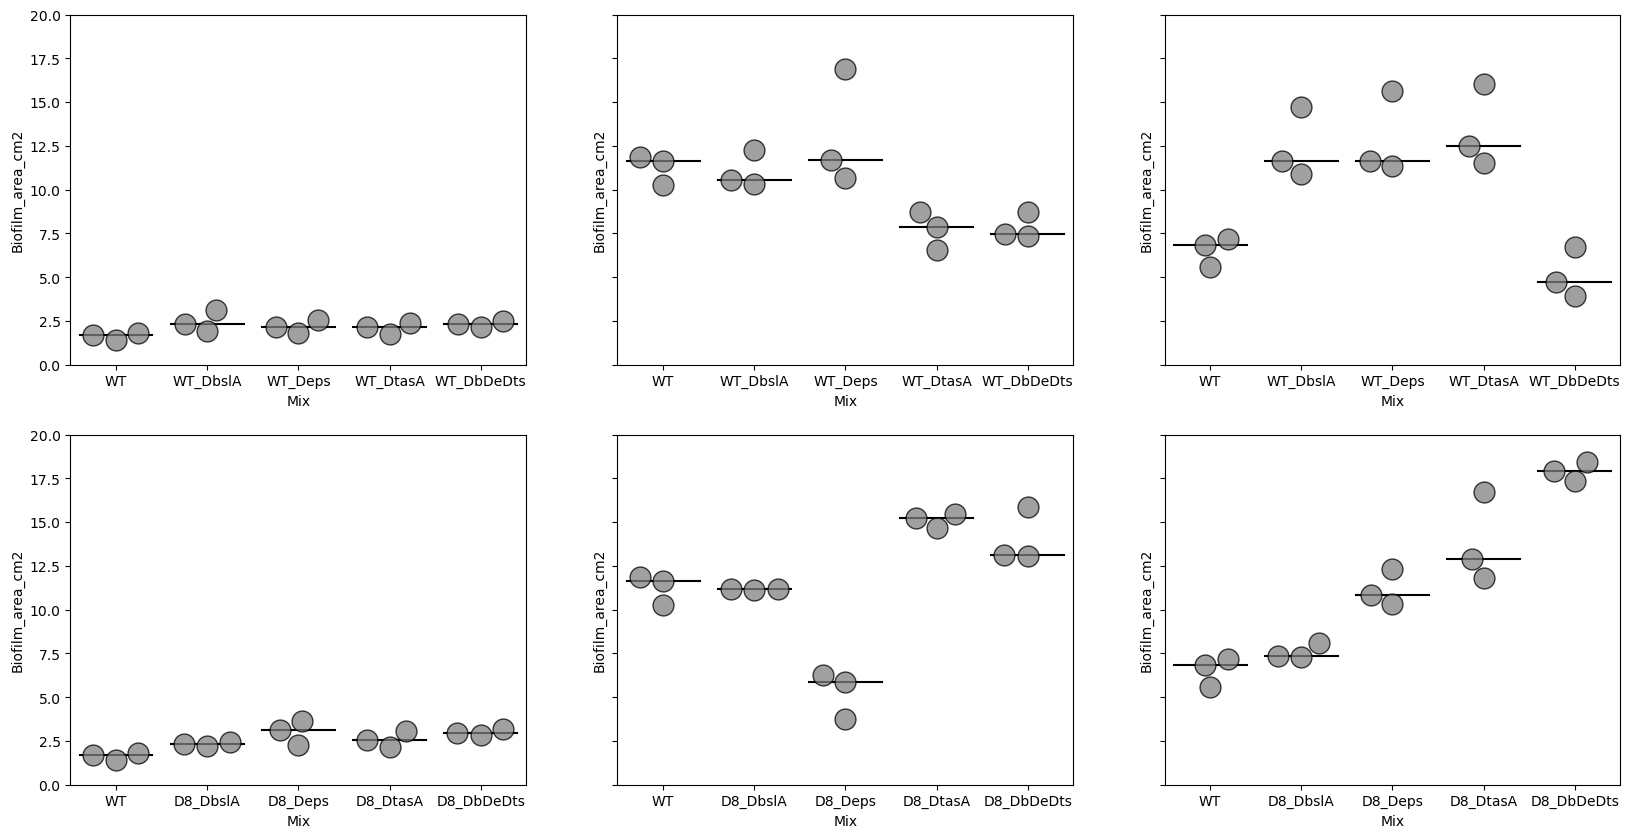

In [64]:
#VISUALISATION 
fig, axs = plt.subplots(2, 3, figsize=(20,10), sharey=True)

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_WT_MSgg_area, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,0])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_WT_MSgg_area, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[0,0])

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSgg_area, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,0])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSgg_area, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[1,0])

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_WT_MSmg_area, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,1])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_WT_MSmg_area, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[0,1])

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSmg_area, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,1])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSmg_area, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[1,1])

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_WT_MSbg_area, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0,2])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_WT_MSbg_area, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[0,2])

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSbg_area, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1,2])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSbg_area, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[1,2])

axs[0,0].set_ylim(0,20)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Fluo_quantif_area.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Fluo_quantif_area.svg", dpi = 300)
plt.show()

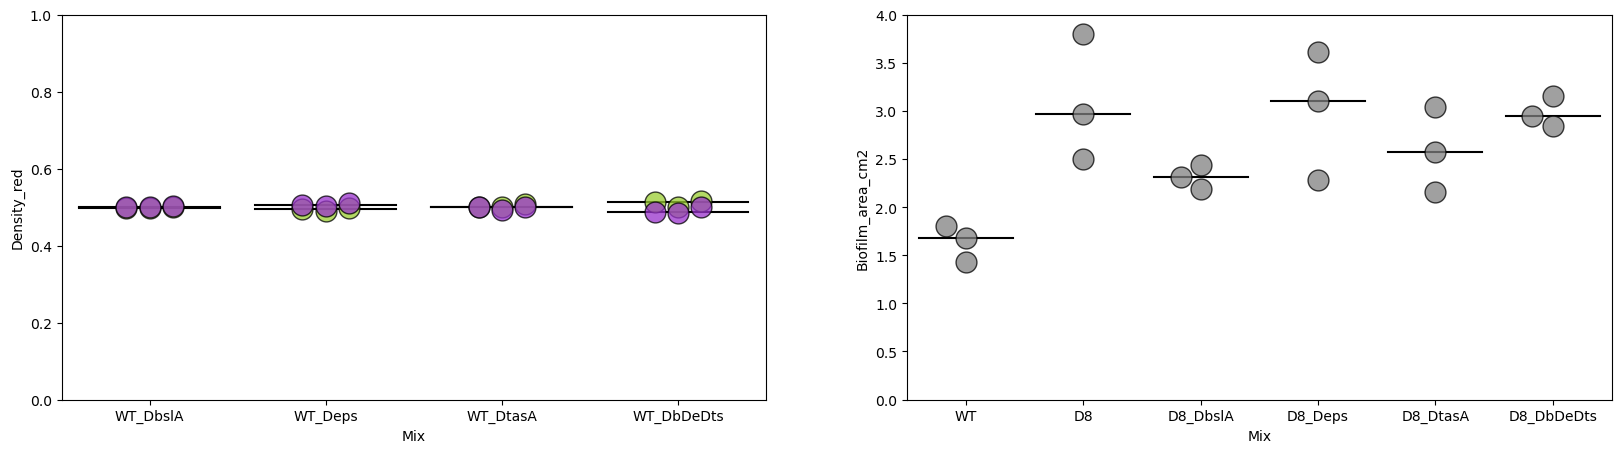

In [65]:
#VISUALISATION 
fluo_quantif_area_WT_2 = fluo_quantif_area[(fluo_quantif_area['Mix'] == 'WT')|(fluo_quantif_area['Mix'] == 'D8')|(fluo_quantif_area['Mix'] == 'WT_DbslA')|(fluo_quantif_area['Mix'] == 'WT_Deps')|(fluo_quantif_area['Mix'] == 'WT_DtasA')|(fluo_quantif_area['Mix'] == 'WT_DbDeDts')]
fluo_quantif_D8_area_2 = fluo_quantif_area[(fluo_quantif_area['Mix'] == 'WT')|(fluo_quantif_area['Mix'] == 'D8')|(fluo_quantif_area['Mix'] == 'D8_DbslA')|(fluo_quantif_area['Mix'] == 'D8_Deps')|(fluo_quantif_area['Mix'] == 'D8_DtasA')|(fluo_quantif_area['Mix'] == 'D8_DbDeDts')]

fluo_quantif_WT_MSgg_area_2 = fluo_quantif_area_WT_2[fluo_quantif_area_WT_2['Medium'] == 'MSgg']
fluo_quantif_WT_MSmg_area_2 = fluo_quantif_area_WT_2[fluo_quantif_area_WT_2['Medium'] == 'MSmg']
fluo_quantif_WT_MSbg_area_2 = fluo_quantif_area_WT_2[fluo_quantif_area_WT_2['Medium'] == 'MSbg']

fluo_quantif_D8_MSgg_area_2 = fluo_quantif_D8_area_2[fluo_quantif_D8_area_2['Medium'] == 'MSgg']
fluo_quantif_D8_MSmg_area_2 = fluo_quantif_D8_area_2[fluo_quantif_D8_area_2['Medium'] == 'MSmg']
fluo_quantif_D8_MSbg_area_2 = fluo_quantif_D8_area_2[fluo_quantif_D8_area_2['Medium'] == 'MSbg']


fig, axs = plt.subplots(1, 2, figsize=(20,5), sharey=False)

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_WT_MSgg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[0])
sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSgg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_WT_MSgg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[0])

sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSgg_area_2, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSgg_area_2, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[1])

axs[0].set_ylim(0,1)
axs[1].set_ylim(0,4)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure5.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure5.svg", dpi = 300)
plt.show()

In [66]:
fluo_quantif_D8_MSgg_area_2.head()

Day Medium Mix  Replicate  \
0     3   MSgg  WT          1   
1     3   MSgg  WT          2   
2     3   MSgg  WT          3   
9     3   MSgg  D8          1   
10    3   MSgg  D8          2   

                                                Label  colonyArea_micron2  \
0   20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...         180264164.3   
1   20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...         168260362.9   
2   20230215_MatrixMutantBiofilms.lif - D3_MSgg_NC...         142683397.8   
9    20230215_MatrixMutantBiofilms.lif - D3_MSgg_D8_1         249655391.1   
10   20230215_MatrixMutantBiofilms.lif - D3_MSgg_D8_2         379938198.3   

    Biofilm_area_cm2  
0           1.802642  
1           1.682604  
2           1.426834  
9           2.496554  
10          3.799382

In [67]:
#STATISTICAL ANALYSIS
#ANOVA test
res = stat()
res.anova_stat(df=fluo_quantif_D8_MSgg_area_2, res_var='Biofilm_area_cm2', anova_model='Biofilm_area_cm2 ~ C(Mix)')
res.anova_summary

df    sum_sq   mean_sq         F    PR(>F)
C(Mix)     5.0  4.644954  0.928991  4.830392  0.011884
Residual  12.0  2.307865  0.192322       NaN       NaN

In [68]:
#Multiple pairwise comparison
res.tukey_hsd(df=fluo_quantif_area, res_var='Biofilm_area_cm2', xfac_var=['Mix','Medium'], anova_model='Biofilm_area_cm2 ~ C(Mix) + C(Medium) + C(Mix):C(Medium)')
df = res.tukey_summary
df.to_csv(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure5.csv")

C:\ProgramData\anaconda3\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]
C:\ProgramData\anaconda3\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]
C:\ProgramData\anaconda3\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, s

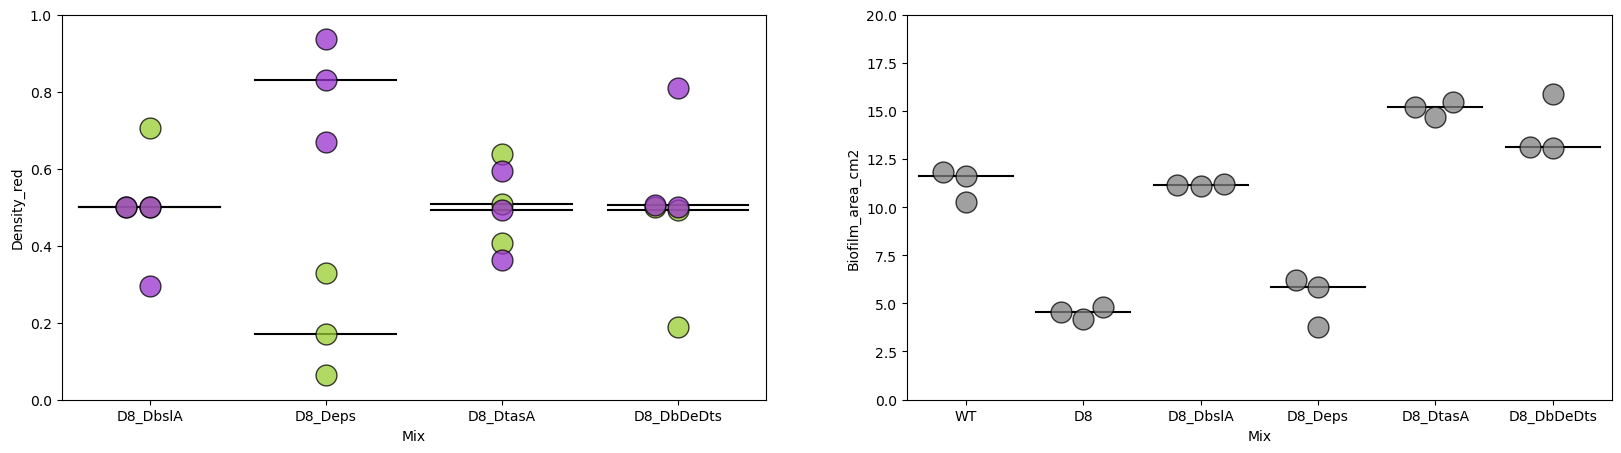

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(20,5), sharey=False)

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSmg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSmg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[0])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSmg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSmg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[0])


sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSmg_area_2, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSmg_area_2, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[1])

axs[0].set_ylim(0,1)
axs[1].set_ylim(0,20)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure7_1.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure7_1.svg", dpi = 300)
plt.show()

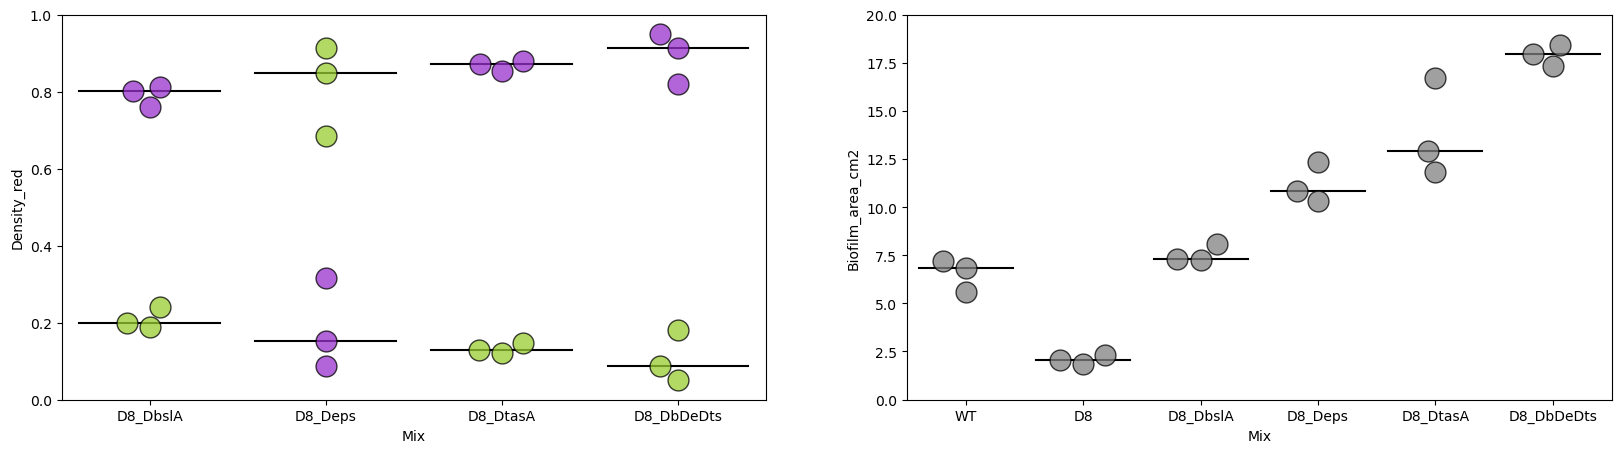

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20,5), sharey=False)

sns.boxplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Mix', y='Density_green', data=fluo_quantif_D8_MSbg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['yellowgreen'], ax=axs[0])

sns.boxplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSbg, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[0])
sns.swarmplot(x='Mix', y='Density_red', data=fluo_quantif_D8_MSbg, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['darkorchid'], ax=axs[0])


sns.boxplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSbg_area_2, whis=0, showbox=False, showcaps=False, showfliers=False, color='Black', ax=axs[1])
sns.swarmplot(x='Mix', y='Biofilm_area_cm2', data=fluo_quantif_D8_MSbg_area_2, s=15,dodge=True, edgecolor='black', linewidth=1, alpha=0.75, color=['Gray'], ax=axs[1])

axs[0].set_ylim(0,1)
axs[1].set_ylim(0,20)

plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure7_2.png", dpi = 300)
plt.savefig(r"C:\Users\Thibault Rosazza\OneDrive - University of Dundee\Documents\_PhD_\Code\Jupyter_Notebooks\Figure\Figure7_2.svg", dpi = 300)
plt.show()